In [7]:
import os
import polars as pl
import dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
FOLDER_PATH = os.getenv("FOLDER_PATH")


dotenv.load_dotenv()
stock = "WBD"

Python-dotenv could not parse statement starting at line 4
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 6
Python-dotenv could not parse statement starting at line 7
Python-dotenv could not parse statement starting at line 8
Python-dotenv could not parse statement starting at line 9
Python-dotenv could not parse statement starting at line 10


In [9]:
parquet_files = [f for f in os.listdir(f"{FOLDER_PATH}/data/hawkes_dataset/{stock}") if f.endswith('.parquet')]
parquet_files.sort()
print(len(parquet_files),"\n",parquet_files)
threshold = len(parquet_files)//10
threshold = 1
parquet_files = parquet_files[:threshold]
# Read and concatenate all parquet files
df = pl.concat([
    pl.read_parquet(f"{FOLDER_PATH}/data/hawkes_dataset/{stock}/{file}") 
    for file in parquet_files
])

74 
 ['WBD_2024-07-22.parquet', 'WBD_2024-07-23.parquet', 'WBD_2024-07-24.parquet', 'WBD_2024-07-25.parquet', 'WBD_2024-07-26.parquet', 'WBD_2024-07-29.parquet', 'WBD_2024-07-30.parquet', 'WBD_2024-07-31.parquet', 'WBD_2024-08-01.parquet', 'WBD_2024-08-02.parquet', 'WBD_2024-08-05.parquet', 'WBD_2024-08-06.parquet', 'WBD_2024-08-07.parquet', 'WBD_2024-08-08.parquet', 'WBD_2024-08-09.parquet', 'WBD_2024-08-12.parquet', 'WBD_2024-08-13.parquet', 'WBD_2024-08-14.parquet', 'WBD_2024-08-15.parquet', 'WBD_2024-08-16.parquet', 'WBD_2024-08-19.parquet', 'WBD_2024-08-20.parquet', 'WBD_2024-08-21.parquet', 'WBD_2024-08-22.parquet', 'WBD_2024-08-23.parquet', 'WBD_2024-08-26.parquet', 'WBD_2024-08-27.parquet', 'WBD_2024-08-28.parquet', 'WBD_2024-08-29.parquet', 'WBD_2024-08-30.parquet', 'WBD_2024-09-03.parquet', 'WBD_2024-09-04.parquet', 'WBD_2024-09-05.parquet', 'WBD_2024-09-06.parquet', 'WBD_2024-09-09.parquet', 'WBD_2024-09-10.parquet', 'WBD_2024-09-11.parquet', 'WBD_2024-09-12.parquet', 'WBD_2

In [17]:
def curate_mid_price(df,stock):
    num_entries_by_publisher = df.group_by("publisher_id").len().sort("len", descending=True)
    if len(num_entries_by_publisher) > 1:
            df = df.filter(pl.col("publisher_id") == 41)
        
        
    if stock == "GOOGL":
        df = df.filter(pl.col("ts_event").dt.hour() >= 13)
        df = df.filter(pl.col("ts_event").dt.hour() <= 20)
        
        
    else:
        df = df.filter(
            (
                (pl.col("ts_event").dt.hour() == 9) & (pl.col("ts_event").dt.minute() >= 35) |
                (pl.col("ts_event").dt.hour() > 9) & (pl.col("ts_event").dt.hour() < 16)
            )
        )
    
    # Remove the first row at 9:30
    df = df.with_row_index("index").filter(
        ~((pl.col("ts_event").dt.hour() == 9) & 
          (pl.col("ts_event").dt.minute() == 30) & 
          (pl.col("index") == df.filter(
              (pl.col("ts_event").dt.hour() == 9) & 
              (pl.col("ts_event").dt.minute() == 30)
          ).with_row_index("index").select("index").min())
        )
    ).drop("index")
    mid_price = (df["ask_px_00"] + df["bid_px_00"]) / 2
    
    
    # managing nans or infs, preceding value filling
    mid_price = mid_price.fill_nan(mid_price.shift(1))
    df = df.with_columns(mid_price=mid_price)
    # now we define the mid price with the microprice, barycenter of bid and ask prices by their weights
    df = df.sort("ts_event")
    return df


df_price = pl.concat([
    pl.read_parquet(f"{FOLDER_PATH}{stock}/{file}") 
    for file in parquet_files
])
df_price = curate_mid_price(df_price,stock)
df_price = df_price["ts_event","mid_price"]


In [18]:
df.head()

shape: (5, 9)
┌─────────────────────────────────┬─────┬─────┬─────┬───┬─────┬─────┬─────┬─────┐
│ ts_event                        ┆ P_a ┆ P_b ┆ T_a ┆ … ┆ L_a ┆ L_b ┆ C_a ┆ C_b │
│ ---                             ┆ --- ┆ --- ┆ --- ┆   ┆ --- ┆ --- ┆ --- ┆ --- │
│ datetime[ns, US/Eastern]        ┆ i32 ┆ i32 ┆ i32 ┆   ┆ i32 ┆ i32 ┆ i32 ┆ i32 │
╞═════════════════════════════════╪═════╪═════╪═════╪═══╪═════╪═════╪═════╪═════╡
│ 2024-07-22 09:30:00.011066936 … ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 1   ┆ 0   ┆ 0   ┆ 0   │
│ 2024-07-22 09:30:00.011079662 … ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 1   ┆ 1   ┆ 0   ┆ 0   │
│ 2024-07-22 09:30:00.011839980 … ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 1   ┆ 2   ┆ 0   ┆ 0   │
│ 2024-07-22 09:30:00.011845202 … ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 2   ┆ 2   ┆ 0   ┆ 0   │
│ 2024-07-22 09:30:00.013075122 … ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 3   ┆ 2   ┆ 0   ┆ 0   │
└─────────────────────────────────┴─────┴─────┴─────┴───┴─────┴─────┴─────┴─────┘

In [19]:
df_price.head()

shape: (5, 2)
┌─────────────────────────────────┬───────────┐
│ ts_event                        ┆ mid_price │
│ ---                             ┆ ---       │
│ datetime[ns, US/Eastern]        ┆ f64       │
╞═════════════════════════════════╪═══════════╡
│ 2024-07-22 09:35:00.001689461 … ┆ 8.515     │
│ 2024-07-22 09:35:00.001985212 … ┆ 8.515     │
│ 2024-07-22 09:35:00.029098385 … ┆ 8.515     │
│ 2024-07-22 09:35:00.217015369 … ┆ 8.515     │
│ 2024-07-22 09:35:00.217059151 … ┆ 8.515     │
└─────────────────────────────────┴───────────┘

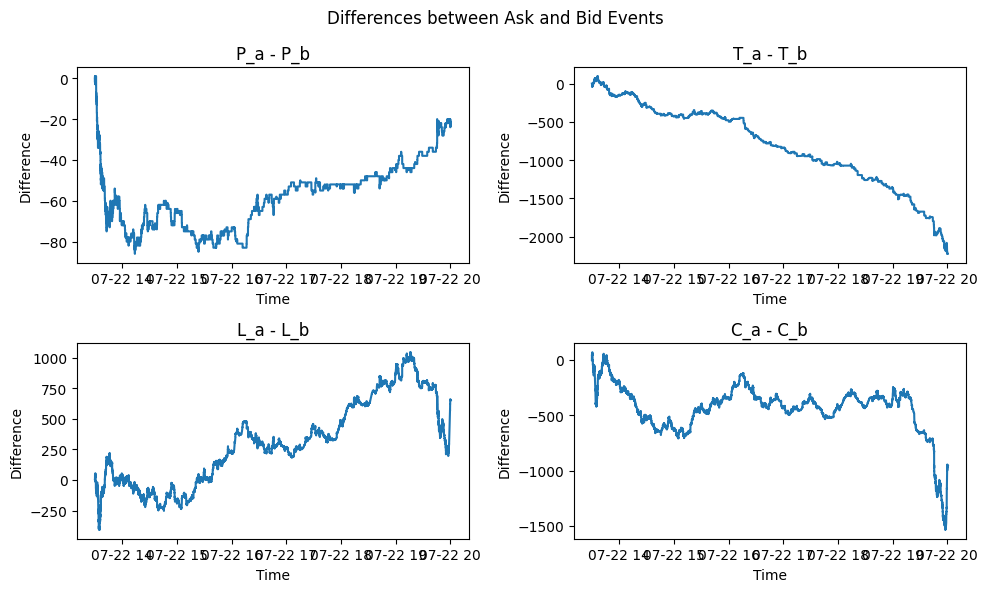

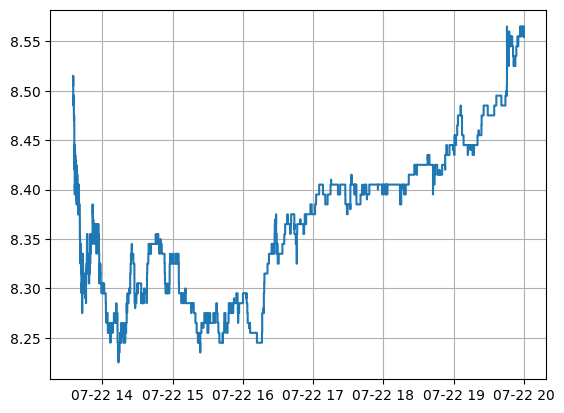

<Figure size 640x480 with 0 Axes>

In [20]:
# Plot differences between ask and bid events
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle('Differences between Ask and Bid Events')

# Plot P_a - P_b
ax1.plot(df['ts_event'], df['P_a'] - df['P_b'])
ax1.set_title('P_a - P_b')
ax1.set_xlabel('Time')
ax1.set_ylabel('Difference')

# Plot T_a - T_b  
ax2.plot(df['ts_event'], df['T_a'] - df['T_b'])
ax2.set_title('T_a - T_b')
ax2.set_xlabel('Time')
ax2.set_ylabel('Difference')

# Plot L_a - L_b
ax3.plot(df['ts_event'], df['L_a'] - df['L_b'])
ax3.set_title('L_a - L_b')
ax3.set_xlabel('Time')
ax3.set_ylabel('Difference')

# Plot C_a - C_b
ax4.plot(df['ts_event'], df['C_a'] - df['C_b'])
ax4.set_title('C_a - C_b')
ax4.set_xlabel('Time')
ax4.set_ylabel('Difference')

plt.tight_layout()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_diff_between_ask_and_bid_events.png")

plt.plot(df_price["ts_event"], df_price["mid_price"])
plt.grid()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_mid_price.png")





> Exp kernel on hawkes, after we will see others long term memory kernels

In [28]:
# Fit multivariate Hawkes process to the data
from hawkes import HawkesProcess, HawkesKernel
import numpy as np

# Convert timestamps to seconds since start
start_time = df["ts_event"].min()
times = (df["ts_event"] - start_time).dt.total_seconds().to_numpy()

# Get event times for each dimension
event_types = ['P_a', 'P_b', 'T_a', 'T_b', 'L_a', 'L_b', 'C_a', 'C_b']
events = []

for event_type in event_types:
    # Get timestamps where count increases
    event_times = times[df[event_type].diff() > 0]
    events.append(event_times)

# Create exponential kernel with decay parameter
kernel = HawkesKernel('exp', decay=1.0)

# Initialize and fit multivariate Hawkes model
hawkes = HawkesProcess(kernel=kernel, baseline='const')
hawkes.fit(events)

# Print fitted parameters
print("\nFitted Hawkes parameters:")
print("Baseline intensities (mu):")
for i, event_type in enumerate(event_types):
    print(f"{event_type}: {hawkes.baseline_params[i]:.6f}")

print("\nExcitation matrix (alpha):")
for i, row_type in enumerate(event_types):
    print(f"\n{row_type} excited by:")
    for j, col_type in enumerate(event_types):
        print(f"{col_type}: {hawkes.kernel_params[i,j]:.6f}")

print("\nDecay rates:")
print(f"Decay parameter: {hawkes.kernel.decay:.6f}")

# Plot intensity for each dimension
t = np.linspace(0, times[-1], 1000)
intensities = hawkes.intensity(t)

fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, (event_type, intensity) in enumerate(zip(event_types, intensities.T)):
    ax = axes[i]
    ax.plot(t, intensity, label='Intensity')
    ax.vlines(events[i], ymin=0, ymax=max(intensity), alpha=0.1)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Hawkes Process Intensity for {event_type}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_multivariate_hawkes_intensity.png")


ModuleNotFoundError: No module named 'hawkes'

shape: (5, 10)
┌──────────────────┬───────────┬────────┬──────┬───┬───────────┬───────────┬───────────┬───────────┐
│ ts_event         ┆ mid_price ┆ action ┆ side ┆ … ┆ bid_px_00 ┆ ask_px_00 ┆ bid_sz_00 ┆ ask_sz_00 │
│ ---              ┆ ---       ┆ ---    ┆ ---  ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ datetime[ns,     ┆ f64       ┆ str    ┆ str  ┆   ┆ f64       ┆ f64       ┆ u32       ┆ u32       │
│ US/Eastern]      ┆           ┆        ┆      ┆   ┆           ┆           ┆           ┆           │
╞══════════════════╪═══════════╪════════╪══════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2024-07-22 09:35 ┆ 8.515     ┆ C      ┆ B    ┆ … ┆ 8.51      ┆ 8.52      ┆ 200       ┆ 3149      │
│ :00.001689461 …  ┆           ┆        ┆      ┆   ┆           ┆           ┆           ┆           │
│ 2024-07-22 09:35 ┆ 8.515     ┆ C      ┆ B    ┆ … ┆ 8.51      ┆ 8.52      ┆ 200       ┆ 3149      │
│ :00.001985212 …  ┆           ┆        ┆      ┆   ┆           ┆           ┆           ┆           │
│ 2024-07-22 09:35 ┆ 8.515     ┆ A      ┆ B    ┆ … ┆ 8.51      ┆ 8.52      ┆ 200       ┆ 3149      │
│ :00.029098385 …  ┆           ┆        ┆      ┆   ┆           ┆           ┆           ┆           │
│ 2024-07-22 09:35 ┆ 8.515     ┆ T      ┆ N    ┆ … ┆ 8.51      ┆ 8.52      ┆ 200       ┆ 3149      │
│ :00.217015369 …  ┆           ┆        ┆      ┆   ┆           ┆           ┆           ┆           │
│ 2024-07-22 09:35 ┆ 8.515     ┆ A      ┆ A    ┆ … ┆ 8.51      ┆ 8.52      ┆ 200       ┆ 3649      │
│ :00.217059151 …  ┆           ┆        ┆      ┆   ┆           ┆           ┆           ┆           │
└──────────────────┴───────────┴────────┴──────┴───┴───────────┴───────────┴───────────┴───────────┘

Average arrival time

In [21]:
# Compute average time between mid price changes
import numpy as np
import matplotlib.pyplot as plt

# Calculate time differences between mid price changes in nanoseconds and convert to milliseconds
time_diffs = df.with_columns(
    mid_price_change=pl.col("mid_price").diff()
).filter(
    pl.col("mid_price_change") != 0
).select(
    (pl.col("ts_event").diff().cast(pl.Int64) / 1_000_000).alias("time_diff_ms")  # Convert to milliseconds
).drop_nulls()

# Filter out times > 1 hour (3600000 milliseconds) 
time_diffs = time_diffs.filter(pl.col("time_diff_ms") <= 36000)

# Take first alpha fraction of data
alpha = 0.1  # Use first 10% of data
time_diffs_np = time_diffs.to_numpy().flatten()[:int(len(time_diffs) * alpha)]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(time_diffs_np, bins='auto', density=True, alpha=0.7)

plt.title(f'Distribution of Time Between Mid Price Changes (<1h) for {stock} (First {alpha*100}% of data)')
plt.xlabel('Time between mid price changes (milliseconds)')
plt.ylabel('Density')
plt.ylim(0,0.0002)
print('Average time between mid price changes:', time_diffs.mean())
avg_arrival_time = time_diffs.mean()["time_diff_ms"][0] 
plt.grid(True, alpha=0.3)

ColumnNotFoundError: mid_price

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'with_columns' <---
DF ["ts_event", "P_a", "P_b", "T_a", ...]; PROJECT */9 COLUMNS

In [10]:

# Save plot
os.makedirs(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/", exist_ok=True)
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_arrival_times.png")


<Figure size 640x480 with 0 Axes>

In [11]:
time_scales = [str(int(k*avg_arrival_time))+"us" for k in [1,5,10,30,100,1000,3000,10000,30000,100000,300000,1000000,3000000]]
print(time_scales)

['319us', '1598us', '3196us', '9589us', '31965us', '319653us', '958961us', '3196538us', '9589616us', '31965389us', '95896167us', '319653890us', '958961672us']


In [12]:
time_scales = time_scales

dfs = {}

for scale in time_scales:
    df_temp = df_cleaned.group_by(pl.col("ts_event").dt.truncate(scale)).agg([
        pl.col("mid_price").last().alias("mid_price")
    ])
    
    df_temp = df_temp.sort("ts_event")
    
    df_temp = df_temp.with_columns(
        tick_variation=pl.when(pl.col("ts_event").dt.date().diff() == 0)
        .then(pl.col("mid_price").diff()/avg_spread)
        .otherwise(None)
    )
    df_temp = df_temp.with_columns(
        log_variation=pl.when(pl.col("ts_event").dt.date().diff() == 0)
        .then(pl.col("mid_price").log().diff())
        .otherwise(None)
    )
    
    dfs[scale] = df_temp
    
    print(f"\n{scale} sampling:")
    print(df_temp.head())


319us sampling:
shape: (5, 4)
┌────────────────────────────────┬───────────┬────────────────┬───────────────┐
│ ts_event                       ┆ mid_price ┆ tick_variation ┆ log_variation │
│ ---                            ┆ ---       ┆ ---            ┆ ---           │
│ datetime[ns, US/Eastern]       ┆ f64       ┆ f64            ┆ f64           │
╞════════════════════════════════╪═══════════╪════════════════╪═══════════════╡
│ 2024-07-22 09:35:00.001627 EDT ┆ 8.510597  ┆ null           ┆ null          │
│ 2024-07-22 09:35:00.001946 EDT ┆ 8.510597  ┆ 0.0            ┆ 0.0           │
│ 2024-07-22 09:35:00.029061 EDT ┆ 8.510597  ┆ 0.0            ┆ 0.0           │
│ 2024-07-22 09:35:00.216952 EDT ┆ 8.51052   ┆ -0.007163      ┆ -0.000009     │
│ 2024-07-22 09:35:00.217271 EDT ┆ 8.504339  ┆ -0.570623      ┆ -0.000726     │
└────────────────────────────────┴───────────┴────────────────┴───────────────┘

1598us sampling:
shape: (5, 4)
┌────────────────────────────────┬───────────┬───────────

In [13]:
"""
import plotly.graph_objects as go

# Create plots for each time scale
for scale in time_scales:
    df_current = dfs[scale]
    
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=df_current["ts_event"], y=df_current["mid_price"], name="Mid Price")
    )
    fig.update_layout(
        title=f"{scale} Sampling",
        xaxis_title="Time", 
        yaxis_title="Mid Price"
    )
    fig.show()
"""

'\nimport plotly.graph_objects as go\n\n# Create plots for each time scale\nfor scale in time_scales:\n    df_current = dfs[scale]\n    \n    fig = go.Figure()\n    fig.add_trace(\n        go.Scatter(x=df_current["ts_event"], y=df_current["mid_price"], name="Mid Price")\n    )\n    fig.update_layout(\n        title=f"{scale} Sampling",\n        xaxis_title="Time", \n        yaxis_title="Mid Price"\n    )\n    fig.show()\n'

In [13]:
# Calculate volatility under Bachelier model
# In Bachelier model, log returns are normally distributed with variance = sigma^2 * dt
# So sigma = sqrt(var(log returns) / dt)
for scale in time_scales:
    df_current = dfs[scale]
    
    # Add time difference column in seconds by converting nanoseconds to seconds
    df_current = df_current.with_columns(
        dt=pl.col("ts_event").diff().cast(pl.Int64) / 1e9  # Convert directly to seconds
    )
    
    # Calculate volatility using log variations and time differences, normalized by avg_spread
    df_current = df_current.with_columns(
        vol_bachelier=pl.when(pl.col("tick_variation").is_not_null())
        .then((pl.col("tick_variation").abs() / pl.col("dt").sqrt()) / avg_spread)
        .otherwise(None)
    )
    
    dfs[scale] = df_current
    
    # Print summary statistics
    print(f"\nBachelier volatility stats for {scale} sampling:")
    print(df_current.select("vol_bachelier").describe())



Bachelier volatility stats for 319us sampling:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ vol_bachelier │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 408471.0      │
│ null_count ┆ 7.0           │
│ mean       ┆ 64.453071     │
│ std        ┆ 291.737415    │
│ min        ┆ 0.0           │
│ 25%        ┆ 0.0           │
│ 50%        ┆ 0.537751      │
│ 75%        ┆ 14.921346     │
│ max        ┆ 16108.944499  │
└────────────┴───────────────┘

Bachelier volatility stats for 1598us sampling:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ vol_bachelier │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 326592.0      │
│ null_count ┆ 7.0           │
│ mean       ┆ 27.338456     │
│ std        ┆ 131.58487     │
│ min        ┆ 0.0           │
│ 25%        ┆ 0.0           │
│ 50%        ┆ 0.37472       │
│ 75%        ┆ 7.464392      │
│ max  

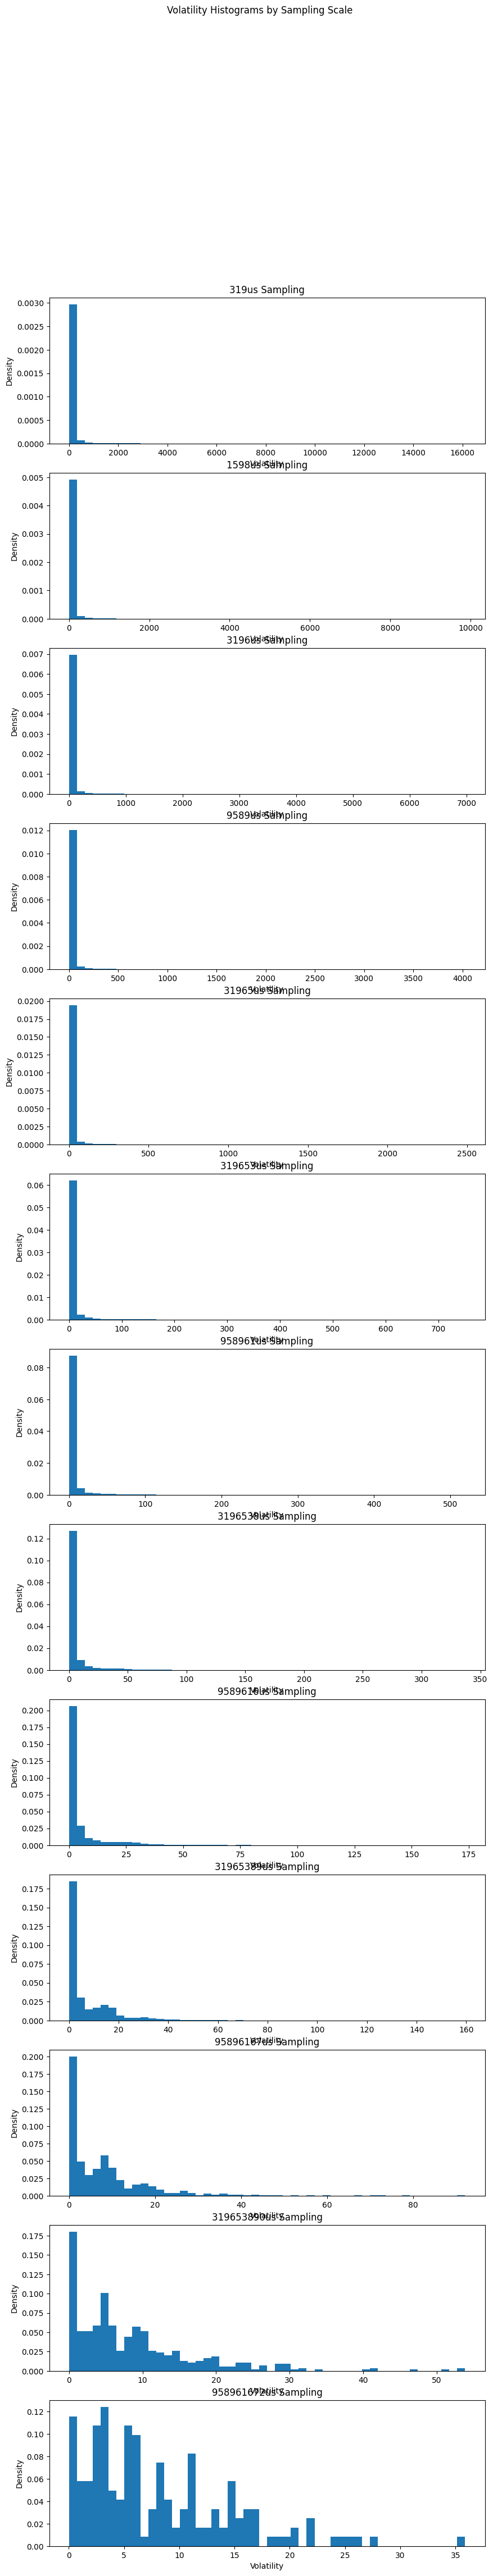

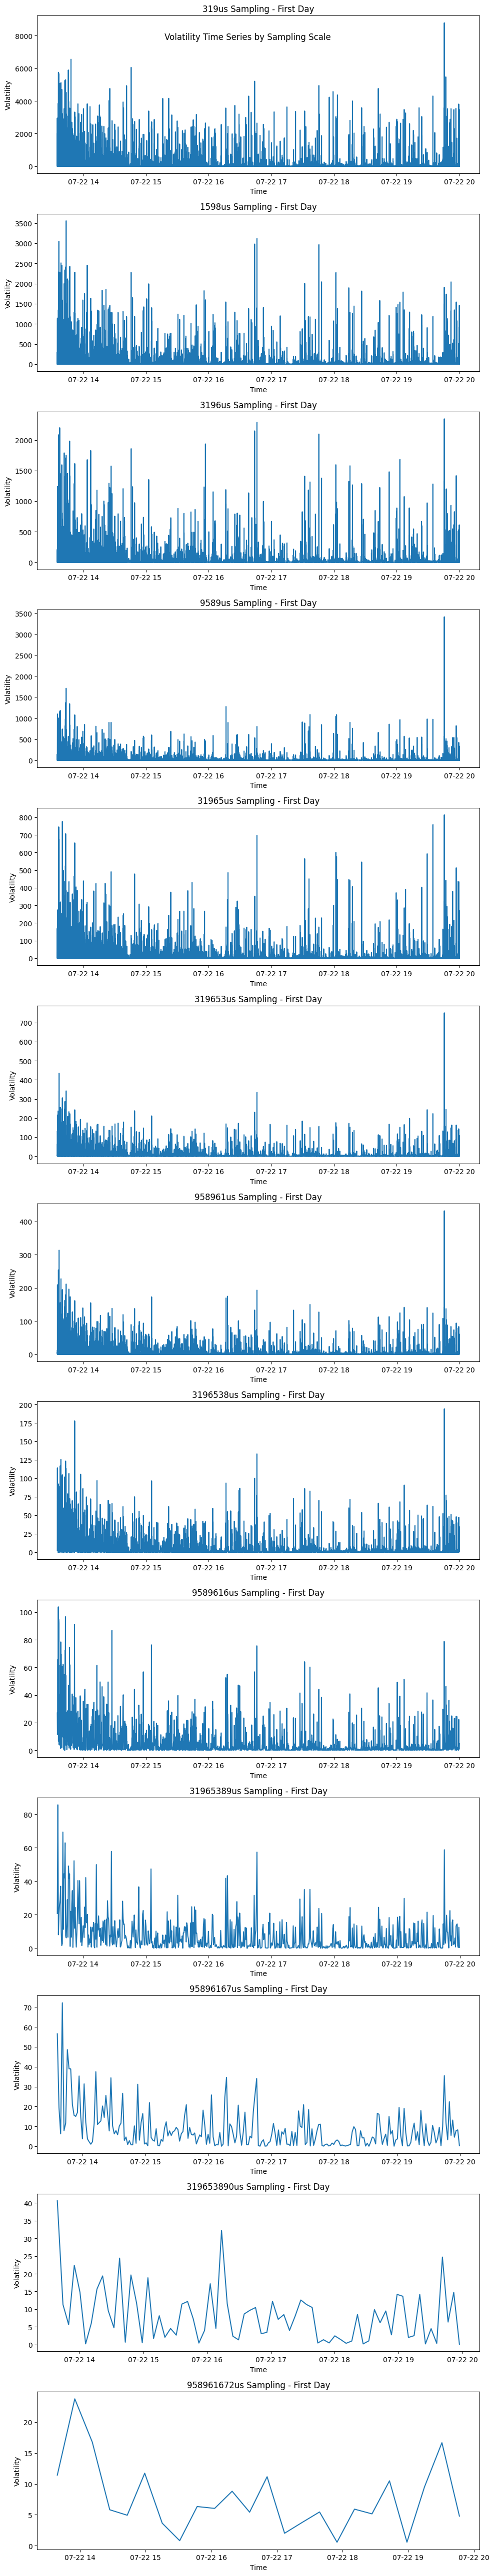

<Figure size 640x480 with 0 Axes>

In [14]:
# Plot histograms and time series of volatility for each sampling scale
import matplotlib.pyplot as plt

# Create subplots for histograms
fig_hist, axes_hist = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_hist.suptitle('Volatility Histograms by Sampling Scale')

# Create subplots for time series
fig_ts, axes_ts = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_ts.suptitle('Volatility Time Series by Sampling Scale')

for i, scale in enumerate(time_scales):
    df_current = dfs[scale]
    
    # Plot histogram
    vol_data = df_current.select('vol_bachelier').to_numpy().flatten()
    axes_hist[i].hist(vol_data[~np.isnan(vol_data)], bins=50, density=True)  # Remove NaN values
    axes_hist[i].set_title(f'{scale} Sampling')
    axes_hist[i].set_xlabel('Volatility')
    axes_hist[i].set_ylabel('Density')
    
    # Plot time series - first day only
    first_day = df_current.select('ts_event').to_numpy()[0].astype('datetime64[D]')
    mask = df_current.select('ts_event').to_numpy().astype('datetime64[D]') == first_day
    
    axes_ts[i].plot(df_current.select('ts_event').to_numpy()[mask], 
                    df_current.select('vol_bachelier').to_numpy()[mask])
    axes_ts[i].set_title(f'{scale} Sampling - First Day')
    axes_ts[i].set_xlabel('Time') 
    axes_ts[i].set_ylabel('Volatility')

plt.tight_layout()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_volatility_histograms_{threshold}.png")

In [20]:
# Calculate volatility under Bachelier model
# In Bachelier model, log returns are normally distributed with variance = sigma^2 * dt
# So sigma = sqrt(var(log returns) / dt)
for scale in time_scales:
    df_current = dfs[scale]
    
    # Add time difference column in seconds by converting nanoseconds to seconds
    df_current = df_current.with_columns(
        dt=pl.col("ts_event").diff().cast(pl.Int64) / 1e9  # Convert directly to seconds
    )
    
    # Calculate volatility using log variations and time differences, normalized by avg_spread
    df_current = df_current.with_columns(
        vol_bachelier=pl.when(pl.col("log_variation").is_not_null())
        .then((pl.col("log_variation").abs() / pl.col("dt").sqrt()) / avg_spread)
        .otherwise(None)
    )
    
    dfs[scale] = df_current
    
    # Print summary statistics
    print(f"\nBachelier volatility stats for {scale} sampling:")
    print(df_current.select("log_variation").describe())



Bachelier volatility stats for 319us sampling:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ log_variation │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 408471.0      │
│ null_count ┆ 7.0           │
│ mean       ┆ 1.8689e-7     │
│ std        ┆ 0.000112      │
│ min        ┆ -0.004386     │
│ 25%        ┆ -0.000003     │
│ 50%        ┆ 0.0           │
│ 75%        ┆ 0.000002      │
│ max        ┆ 0.004315      │
└────────────┴───────────────┘

Bachelier volatility stats for 1598us sampling:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ log_variation │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 326592.0      │
│ null_count ┆ 7.0           │
│ mean       ┆ 2.3375e-7     │
│ std        ┆ 0.000128      │
│ min        ┆ -0.004386     │
│ 25%        ┆ -0.000003     │
│ 50%        ┆ 0.0           │
│ 75%        ┆ 0.000002      │
│ max  

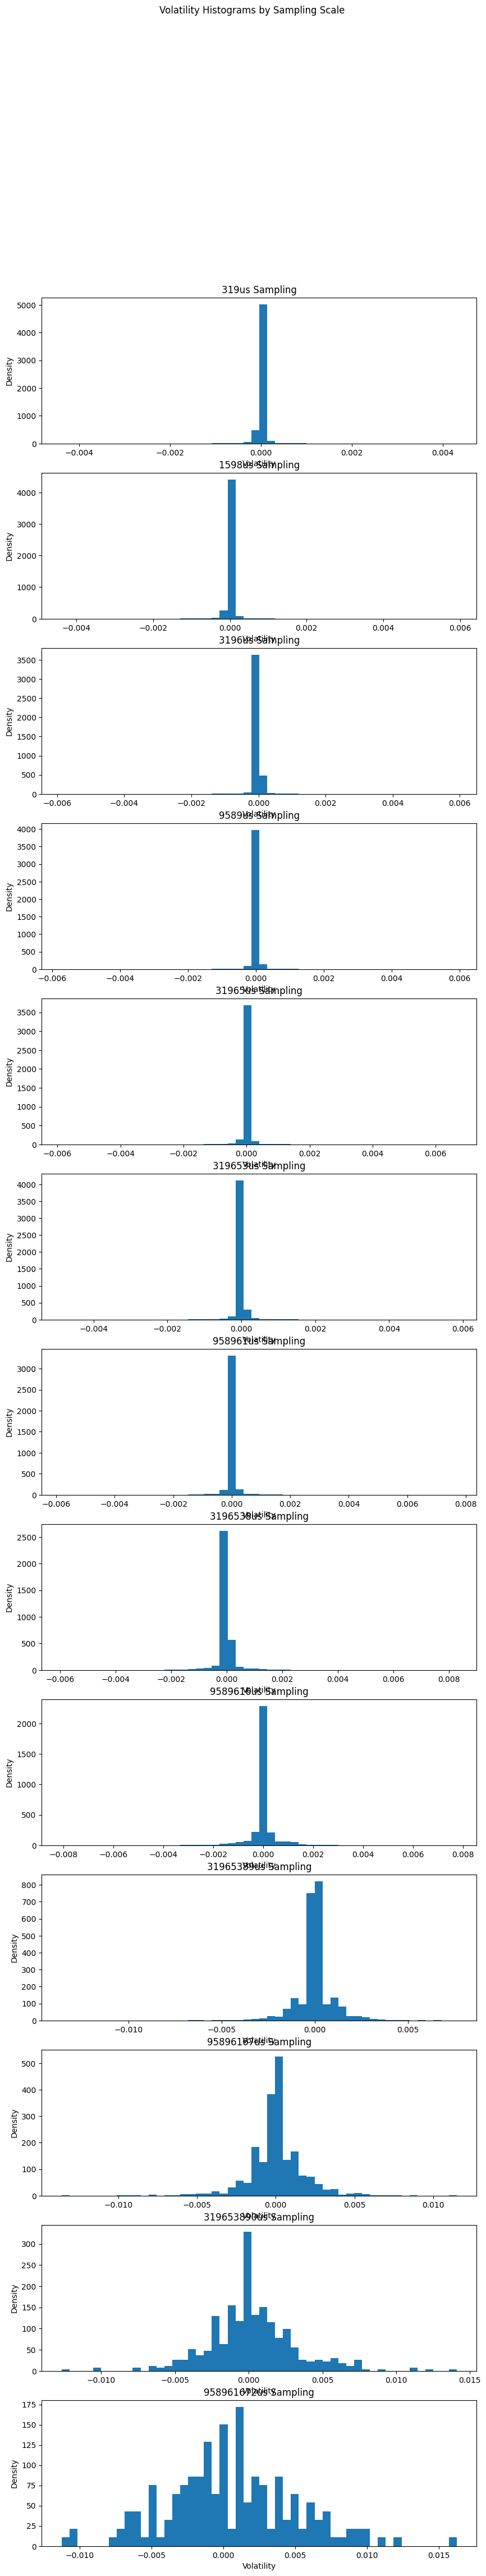

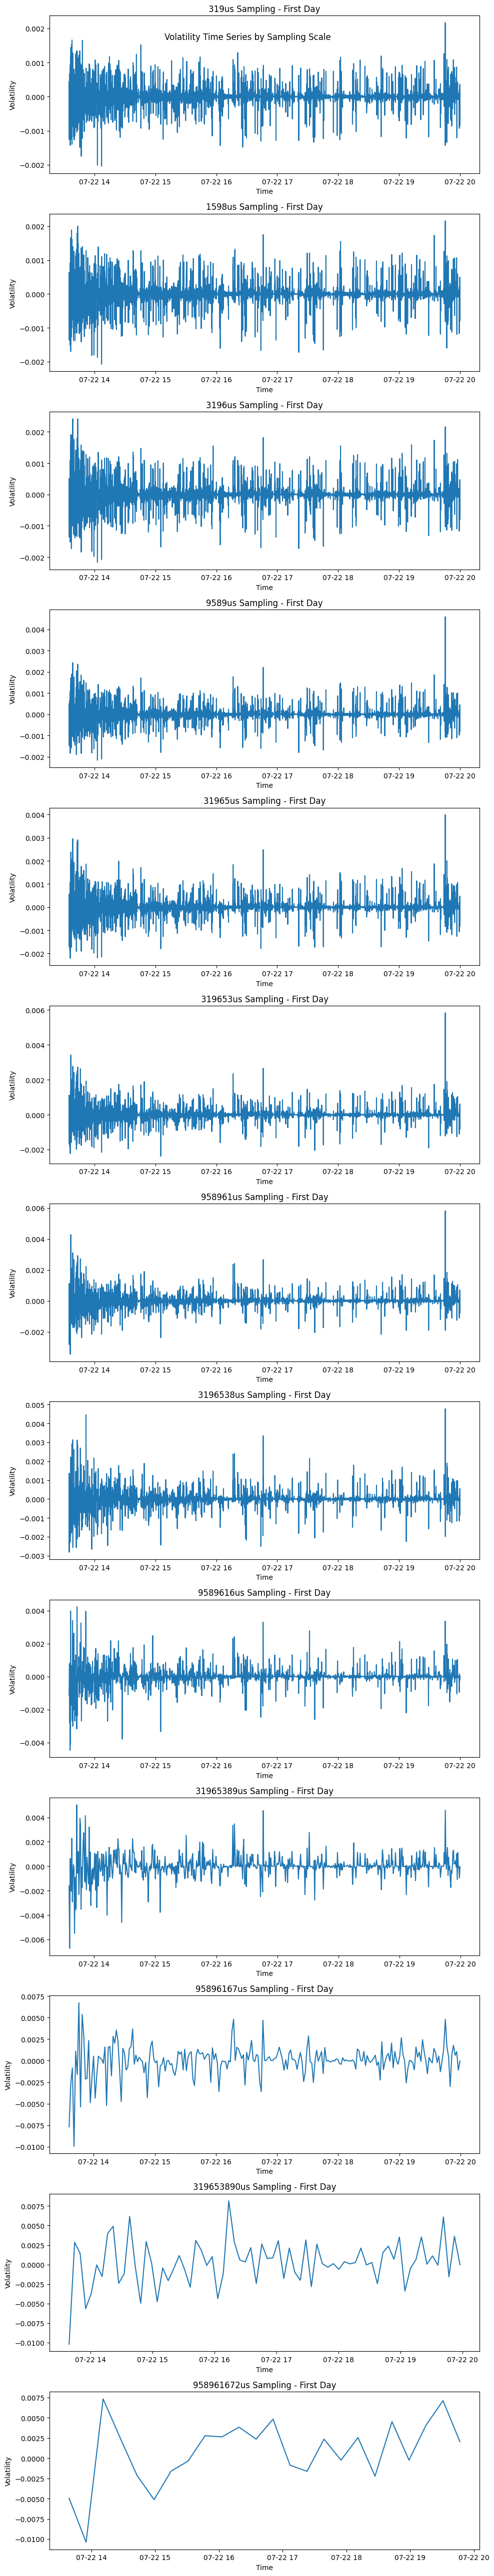

In [21]:
# Plot histograms and time series of volatility for each sampling scale
import matplotlib.pyplot as plt

# Create subplots for histograms
fig_hist, axes_hist = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_hist.suptitle('Volatility Histograms by Sampling Scale')

# Create subplots for time series
fig_ts, axes_ts = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_ts.suptitle('Volatility Time Series by Sampling Scale')

for i, scale in enumerate(time_scales):
    df_current = dfs[scale]
    
    # Plot histogram
    vol_data = df_current.select('log_variation').to_numpy().flatten()
    axes_hist[i].hist(vol_data[~np.isnan(vol_data)], bins=50, density=True)  # Remove NaN values
    axes_hist[i].set_title(f'{scale} Sampling')
    axes_hist[i].set_xlabel('Volatility')
    axes_hist[i].set_ylabel('Density')
    
    # Plot time series - first day only
    first_day = df_current.select('ts_event').to_numpy()[0].astype('datetime64[D]')
    mask = df_current.select('ts_event').to_numpy().astype('datetime64[D]') == first_day
    
    axes_ts[i].plot(df_current.select('ts_event').to_numpy()[mask], 
                    df_current.select('log_variation').to_numpy()[mask])
    axes_ts[i].set_title(f'{scale} Sampling - First Day')
    axes_ts[i].set_xlabel('Time') 
    axes_ts[i].set_ylabel('Volatility')

plt.tight_layout()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_volatility_histograms_{threshold}.png")
plt.close("all")

In [23]:
for scale in time_scales:
    # describe all columns
    print(dfs[scale].describe())

shape: (9, 7)
┌────────────┬──────────────┬───────────┬──────────────┬──────────────┬──────────────┬─────────────┐
│ statistic  ┆ ts_event     ┆ mid_price ┆ tick_variati ┆ log_variatio ┆ dt           ┆ vol_bacheli │
│ ---        ┆ ---          ┆ ---       ┆ on           ┆ n            ┆ ---          ┆ er          │
│ str        ┆ str          ┆ f64       ┆ ---          ┆ ---          ┆ f64          ┆ ---         │
│            ┆              ┆           ┆ f64          ┆ f64          ┆              ┆ f64         │
╞════════════╪══════════════╪═══════════╪══════════════╪══════════════╪══════════════╪═════════════╡
│ count      ┆ 408478       ┆ 408478.0  ┆ 408471.0     ┆ 408471.0     ┆ 408477.0     ┆ 408471.0    │
│ null_count ┆ 0            ┆ 0.0       ┆ 7.0          ┆ 7.0          ┆ 1.0          ┆ 7.0         │
│ mean       ┆ 2024-07-26   ┆ 8.401067  ┆ 0.000144     ┆ 1.8689e-7    ┆ 1.748691     ┆ 0.083528    │
│            ┆ 03:19:27.928 ┆           ┆              ┆              ┆      

In [33]:
time_scales = time_scales[::-1]

Calculating autocorrelation for each scale:   0%|          | 0/13 [00:00<?, ?it/s]

958961672us


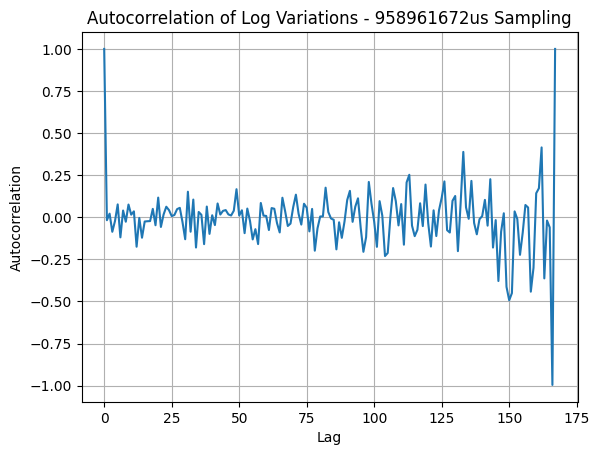

Calculating autocorrelation for each scale:   8%|▊         | 1/13 [00:00<00:01,  8.65it/s]

319653890us


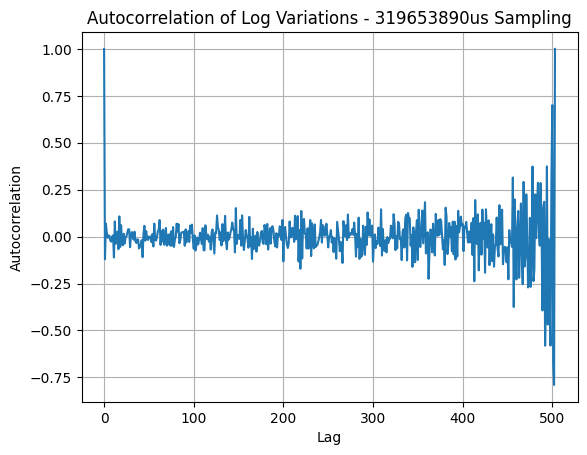

Calculating autocorrelation for each scale:  15%|█▌        | 2/13 [00:00<00:01,  9.38it/s]

95896167us


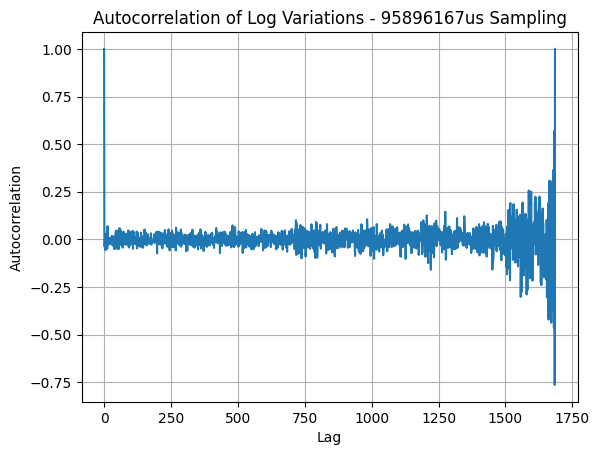

Calculating autocorrelation for each scale:  23%|██▎       | 3/13 [00:00<00:01,  8.00it/s]

31965389us


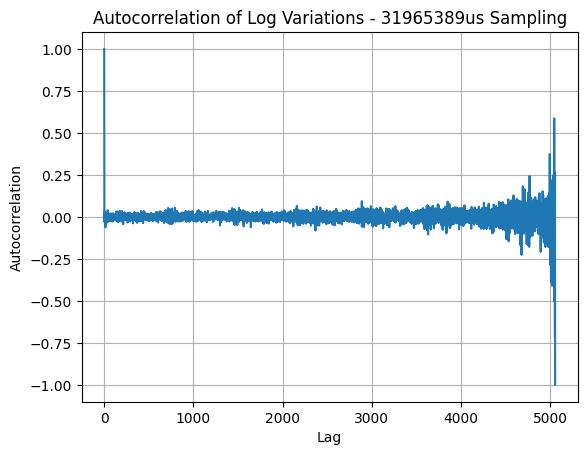

Calculating autocorrelation for each scale:  31%|███       | 4/13 [00:00<00:01,  5.21it/s]

9589616us


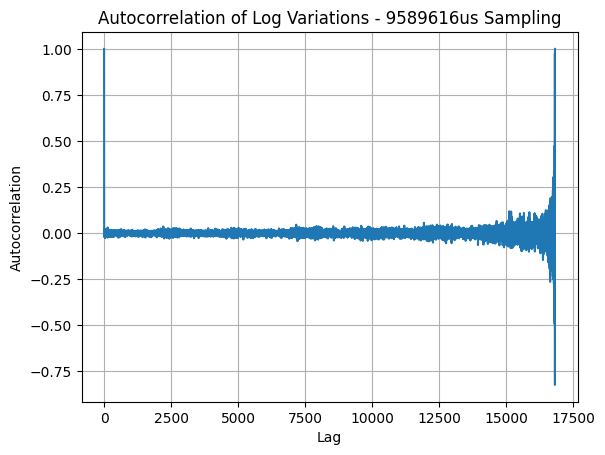

Calculating autocorrelation for each scale:  38%|███▊      | 5/13 [00:01<00:03,  2.05it/s]

3196538us


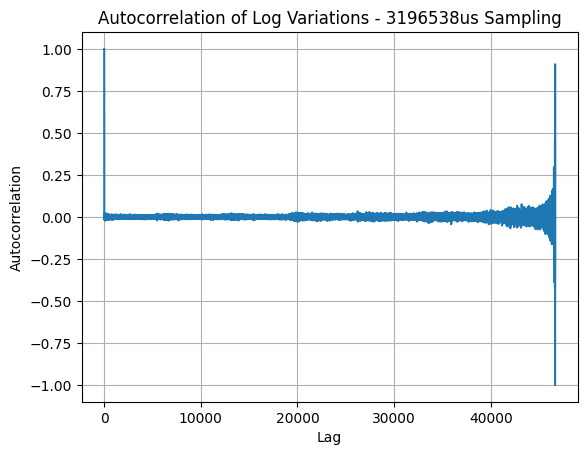

Calculating autocorrelation for each scale:  46%|████▌     | 6/13 [00:06<00:13,  1.97s/it]

958961us


Calculating autocorrelation for each scale:  46%|████▌     | 6/13 [00:07<00:08,  1.26s/it]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [37]:
#plot autocorrelation of log variations

for scale in tqdm(time_scales[::-1], "Calculating autocorrelation for each scale"):
    # to npy and remove nans
    print(scale)
    log_var = dfs[scale].select("log_variation").to_numpy().flatten()
    log_var = log_var[~np.isnan(log_var)]
    n = len(log_var)
    lags = np.arange(n)
    autocorr = np.array([np.corrcoef(log_var[:-lag], log_var[lag:])[0,1] if lag > 0 else 1 for lag in lags])

    plt.plot(lags, autocorr)
    plt.title(f"Autocorrelation of Log Variations - {scale} Sampling")
    plt.xlabel("Lag")
    plt.grid()
    plt.ylabel("Autocorrelation")
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_autocorrelation_{scale}log_var_vanilla.png")


Calculating autocorrelation for each scale:   0%|          | 0/13 [00:00<?, ?it/s]/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


958961672us


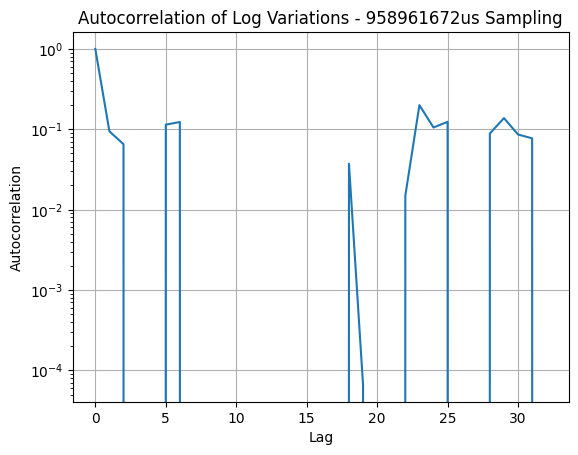

Calculating autocorrelation for each scale:   8%|▊         | 1/13 [00:00<00:05,  2.19it/s]

319653890us


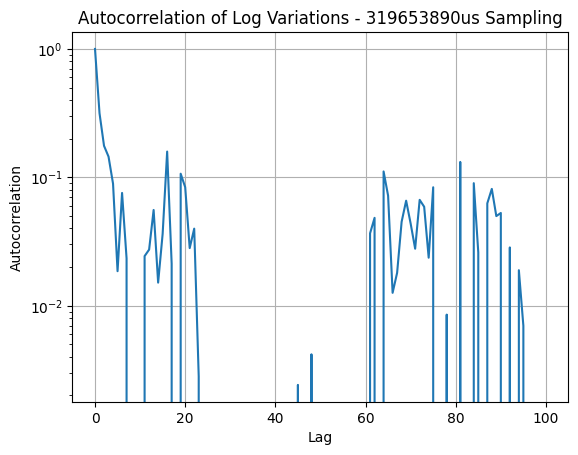

Calculating autocorrelation for each scale:  15%|█▌        | 2/13 [00:00<00:03,  3.20it/s]

95896167us


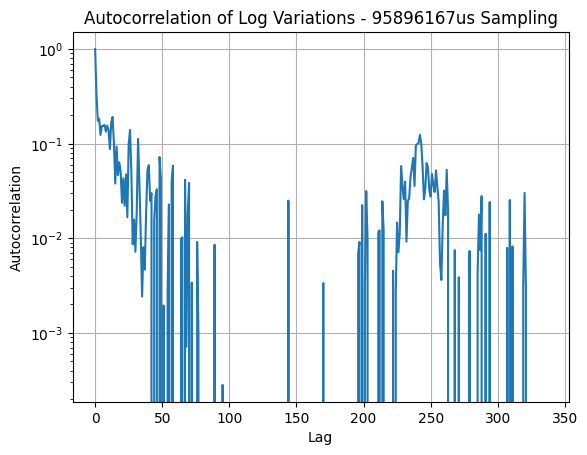

Calculating autocorrelation for each scale:  23%|██▎       | 3/13 [00:00<00:02,  3.56it/s]

31965389us


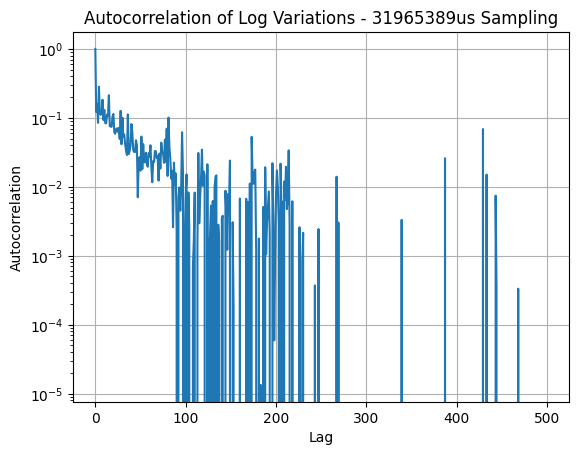

Calculating autocorrelation for each scale:  31%|███       | 4/13 [00:01<00:03,  2.99it/s]

9589616us


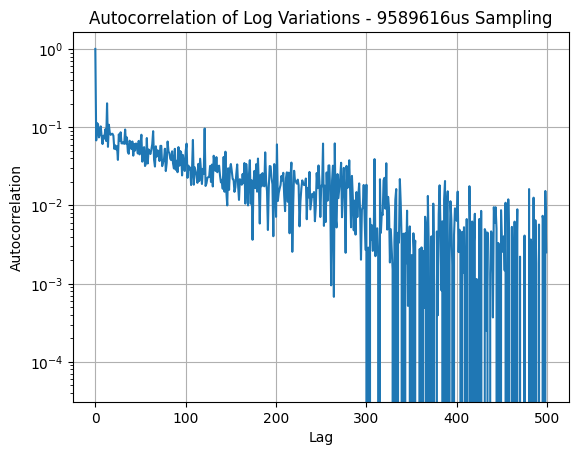

Calculating autocorrelation for each scale:  38%|███▊      | 5/13 [00:02<00:05,  1.56it/s]

3196538us


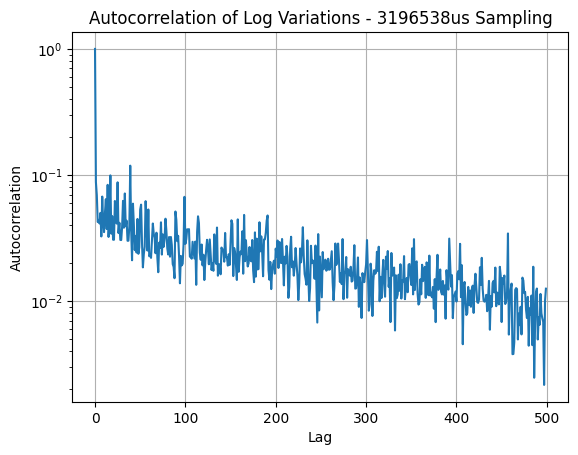

Calculating autocorrelation for each scale:  46%|████▌     | 6/13 [00:07<00:15,  2.16s/it]

958961us


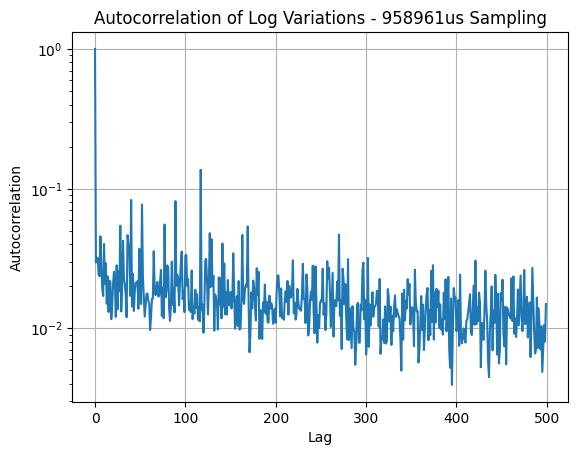

Calculating autocorrelation for each scale:  54%|█████▍    | 7/13 [00:29<00:52,  8.70s/it]

319653us


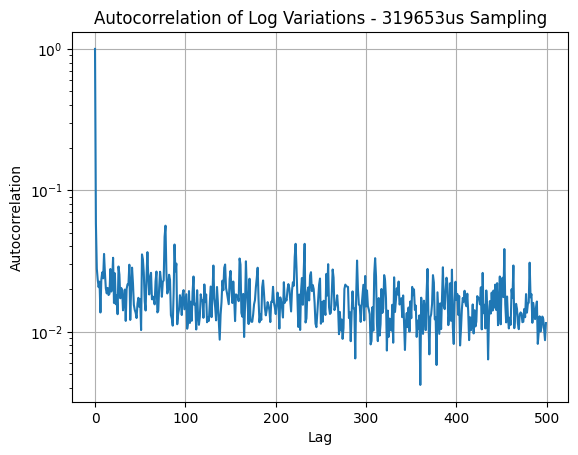

Calculating autocorrelation for each scale:  62%|██████▏   | 8/13 [01:12<01:38, 19.67s/it]

31965us


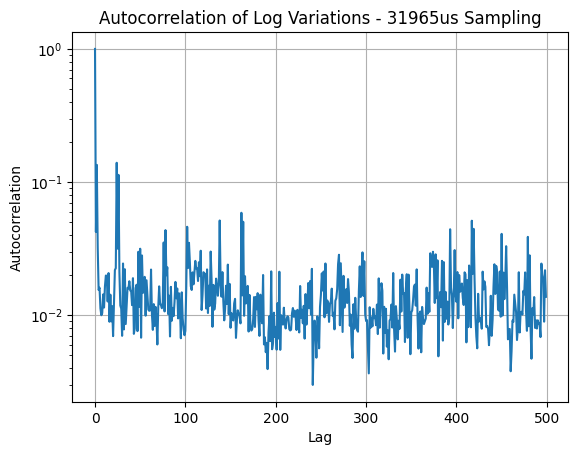

Calculating autocorrelation for each scale:  69%|██████▉   | 9/13 [02:45<02:50, 42.61s/it]

9589us


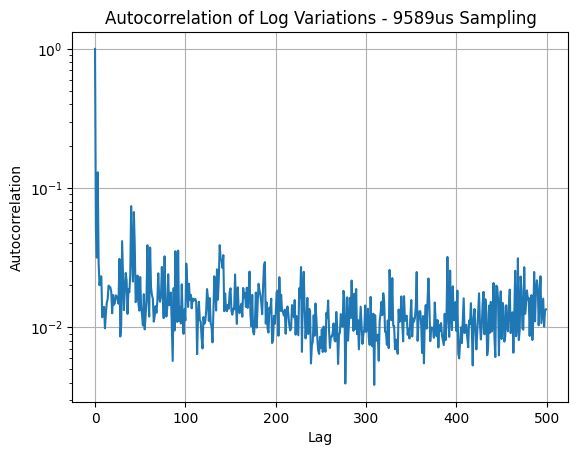

Calculating autocorrelation for each scale:  77%|███████▋  | 10/13 [04:53<03:26, 68.70s/it]

3196us


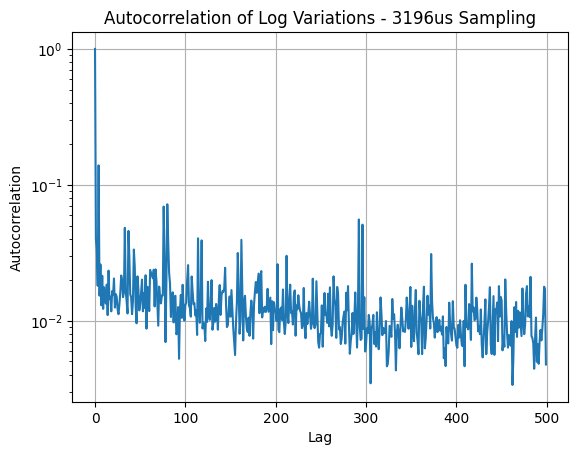

Calculating autocorrelation for each scale:  85%|████████▍ | 11/13 [07:47<03:22, 101.05s/it]

1598us


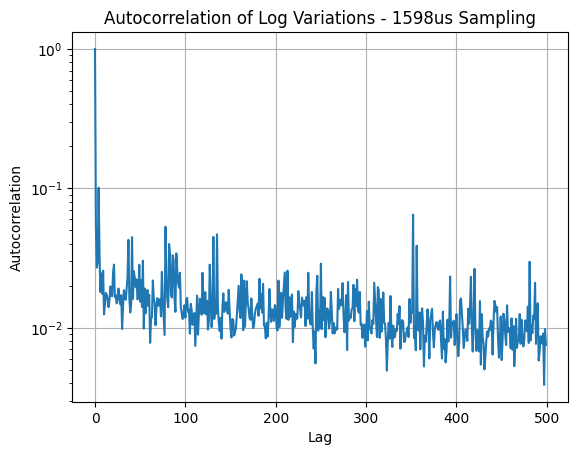

Calculating autocorrelation for each scale:  92%|█████████▏| 12/13 [11:13<02:12, 132.85s/it]

319us


/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


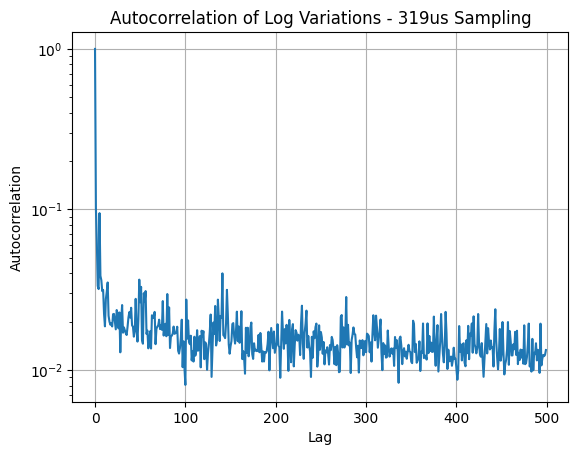

Calculating autocorrelation for each scale: 100%|██████████| 13/13 [16:34<00:00, 76.53s/it] 


<Figure size 640x480 with 0 Axes>

In [41]:
#plot autocorrelation of log variations

for scale in tqdm(time_scales[::-1], "Calculating autocorrelation for each scale"):
    # to npy and remove nans
    print(scale)
    log_var = dfs[scale].select("log_variation").to_numpy().flatten()
    log_var = log_var[~np.isnan(log_var)]
    log_var = log_var * log_var
    n = len(log_var)
    lags = np.arange(n)
    autocorr = np.array([np.corrcoef(log_var[:-lag], log_var[lag:])[0,1] if lag > 0 else 1 for lag in lags])

    plt.plot(lags[:min(500,len(lags)//5)], autocorr[:min(500,len(lags)//5)])
    plt.title(f"Autocorrelation of Log Variations - {scale} Sampling")
    plt.xlabel("Lag")
    plt.grid()
    plt.yscale("log")
    plt.ylabel("Autocorrelation")
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_autocorrelation_{scale}_squared_logvar_betterviz_500_log.png")


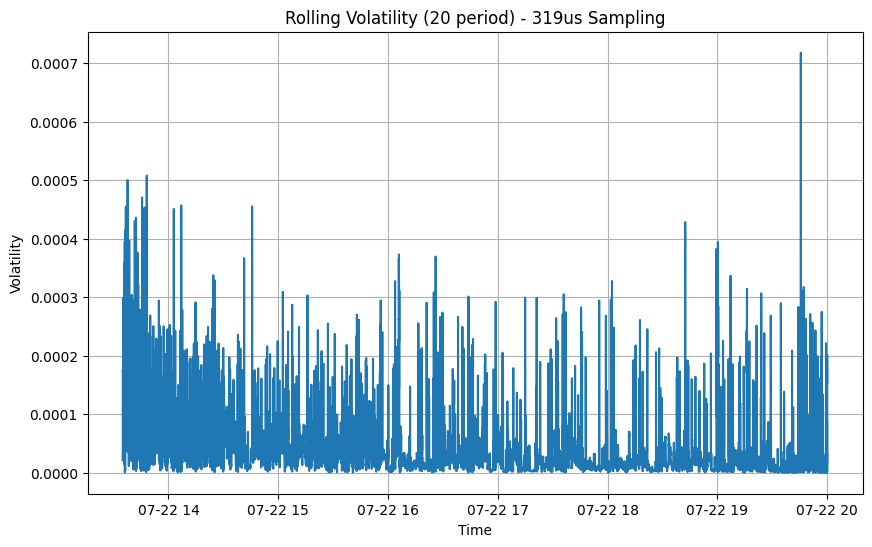

<Figure size 640x480 with 0 Axes>

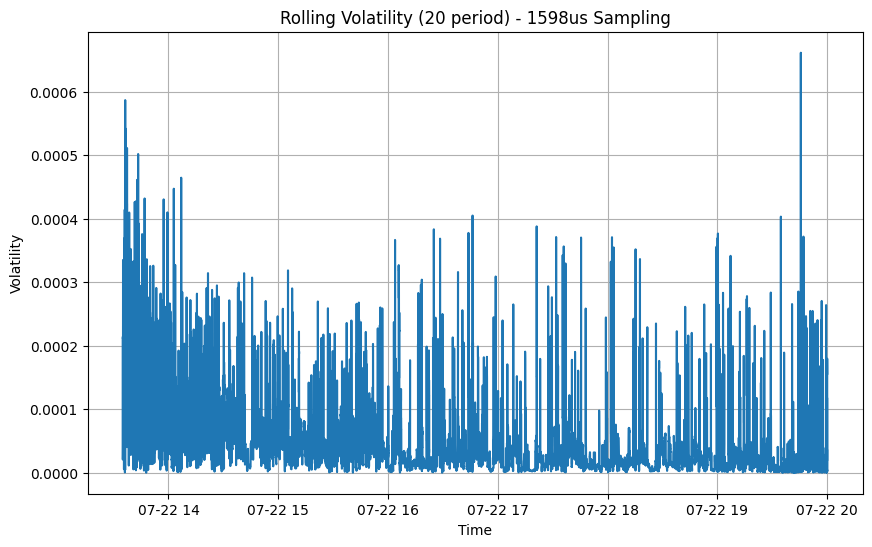

<Figure size 640x480 with 0 Axes>

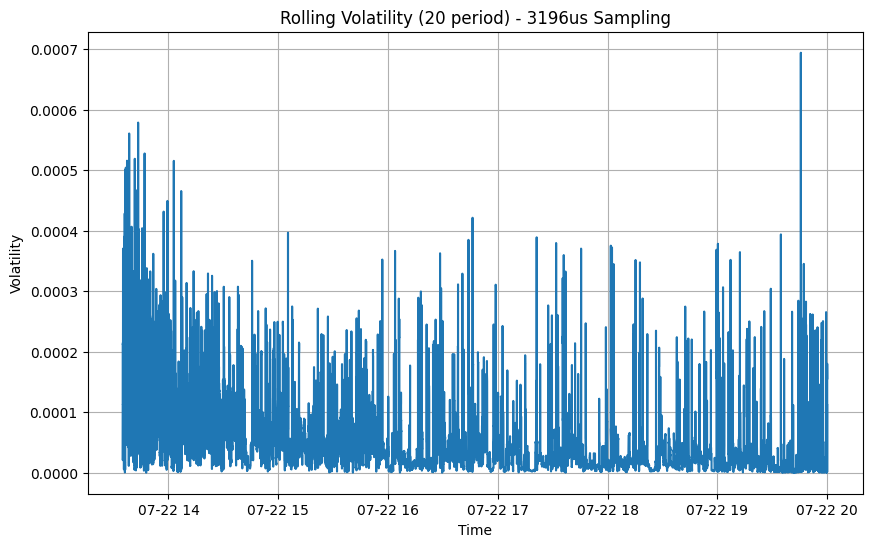

<Figure size 640x480 with 0 Axes>

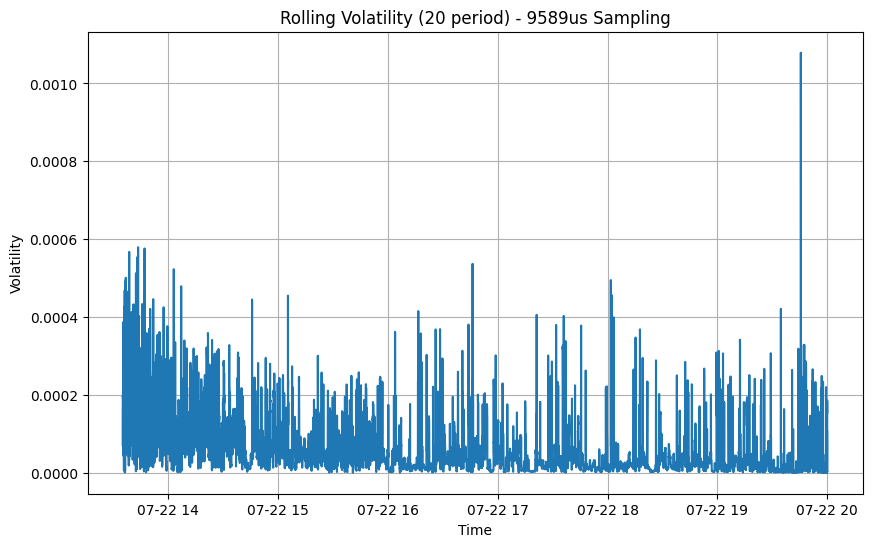

<Figure size 640x480 with 0 Axes>

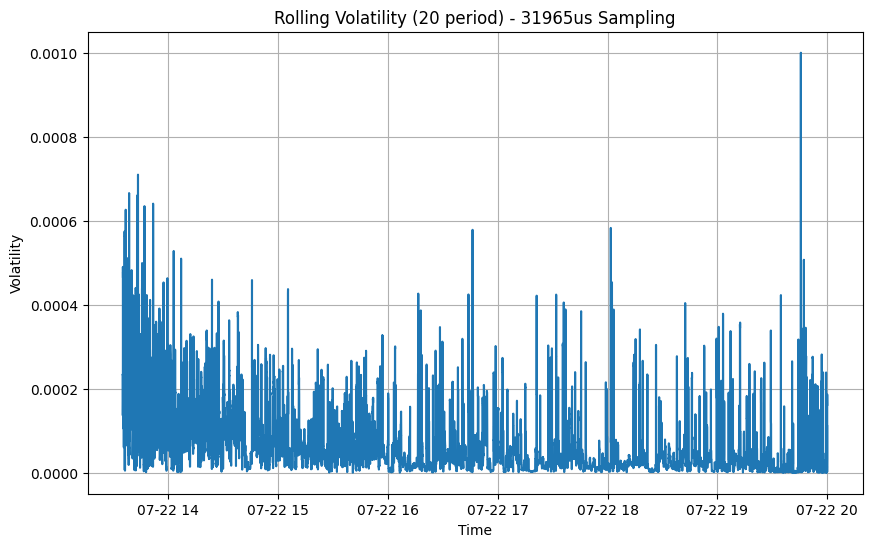

<Figure size 640x480 with 0 Axes>

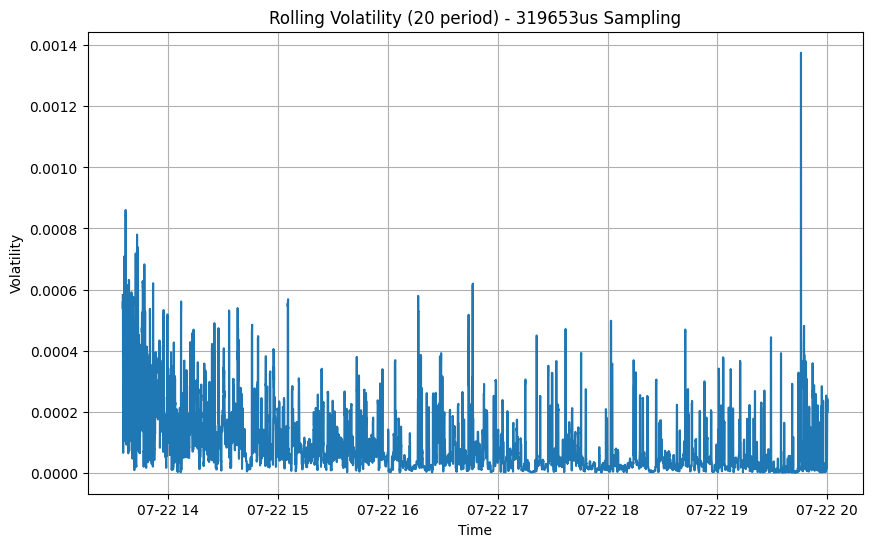

<Figure size 640x480 with 0 Axes>

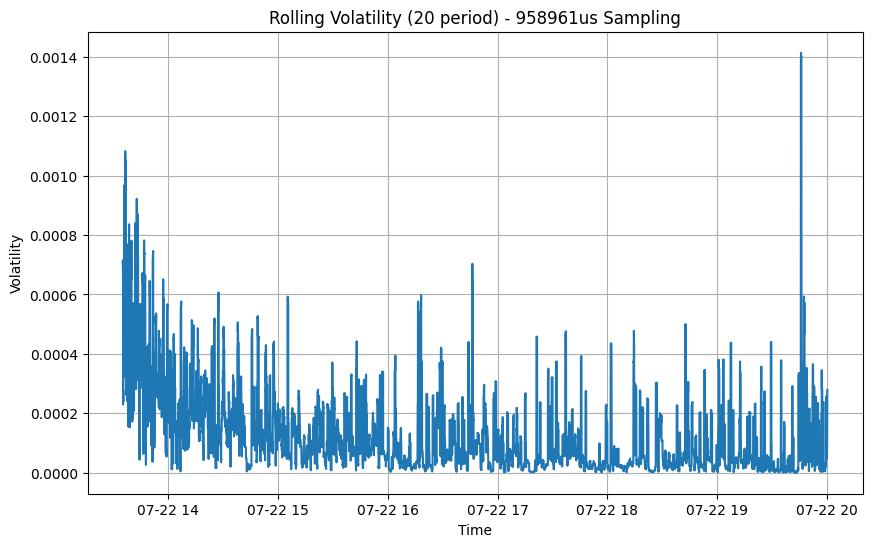

<Figure size 640x480 with 0 Axes>

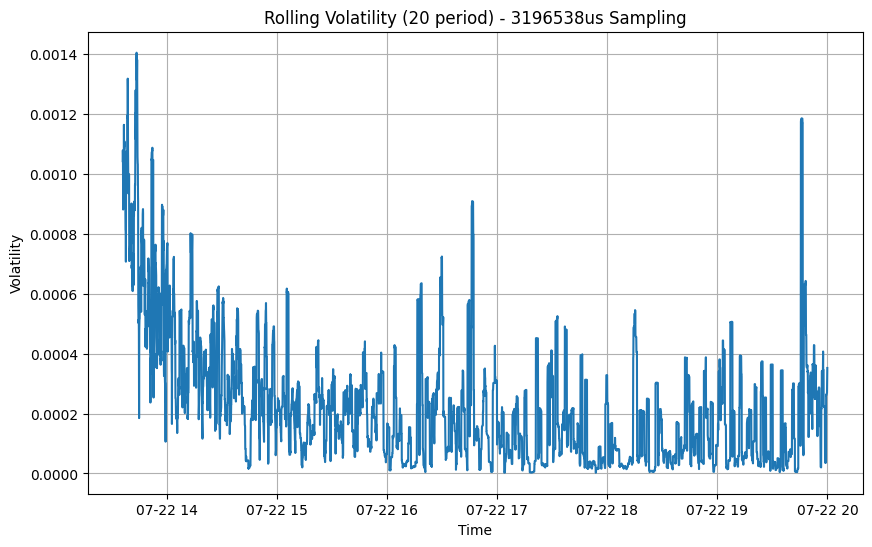

<Figure size 640x480 with 0 Axes>

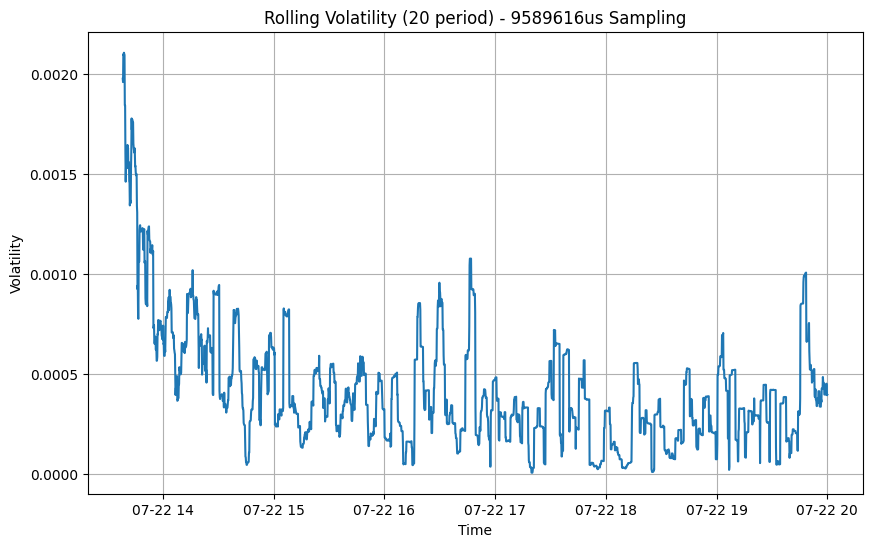

<Figure size 640x480 with 0 Axes>

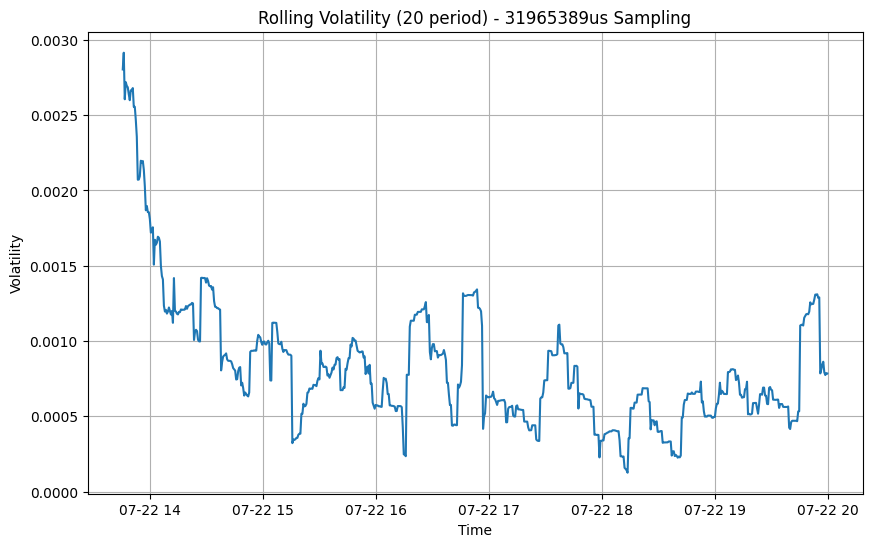

<Figure size 640x480 with 0 Axes>

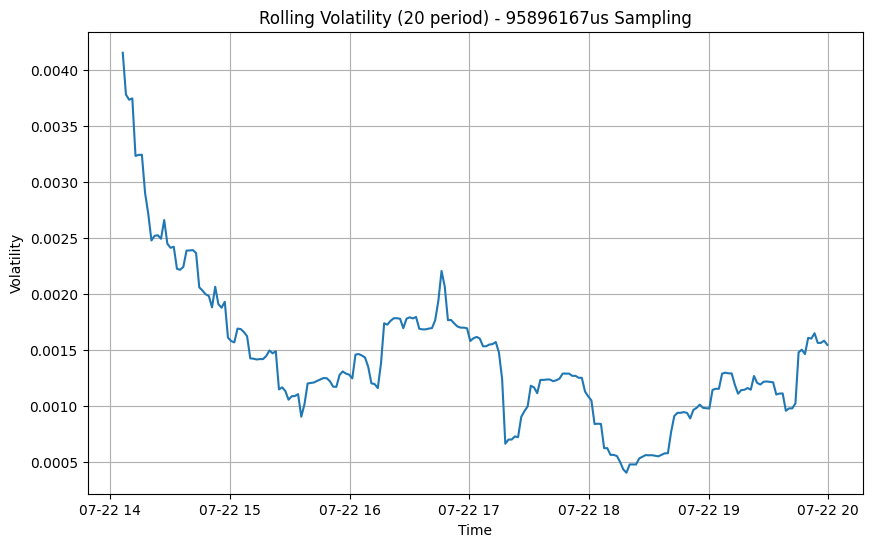

<Figure size 640x480 with 0 Axes>

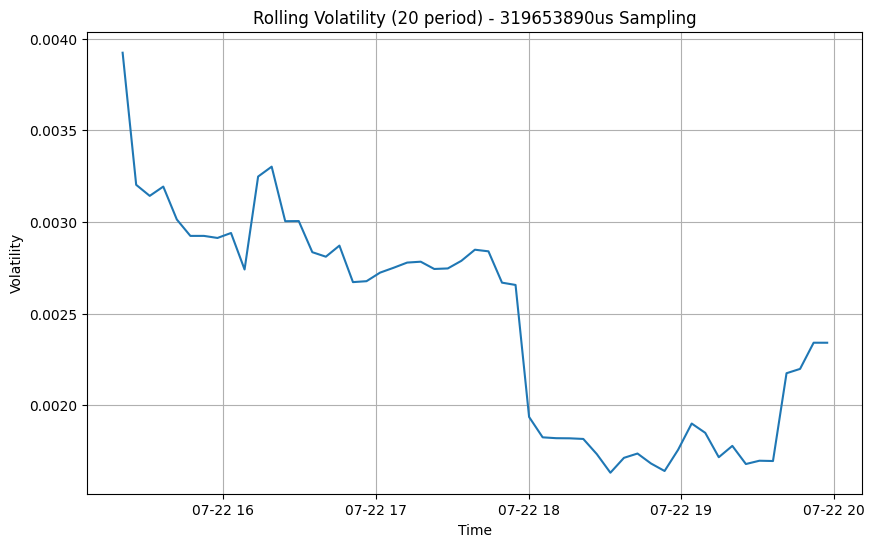

<Figure size 640x480 with 0 Axes>

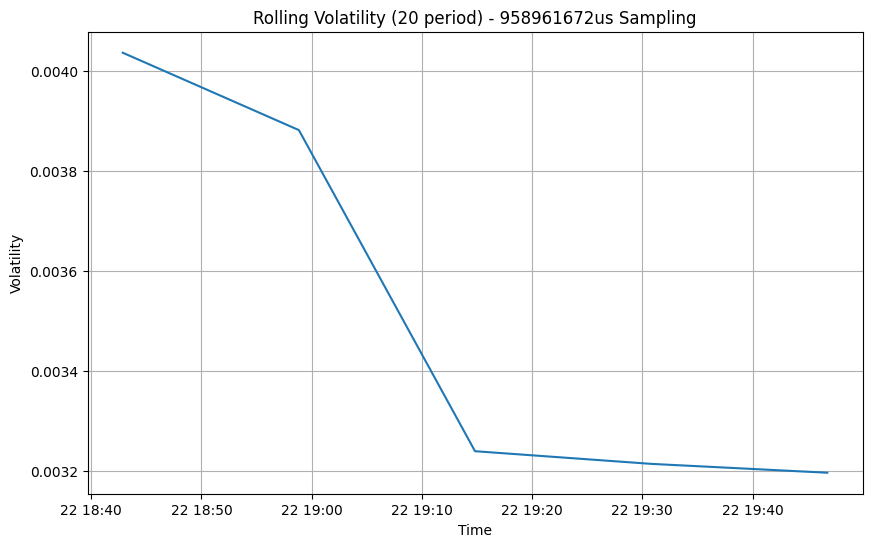

<Figure size 640x480 with 0 Axes>

In [45]:
# Compute volatility as rolling mean of squared log variations
window_size = 20  # Number of periods to use for rolling window

for scale in time_scales:
    # Square the log variations 
    dfs[scale] = dfs[scale].with_columns(
        pl.col("log_variation").pow(2).alias("squared_log_var")
    )
    
    # Calculate rolling mean volatility
    dfs[scale] = dfs[scale].with_columns(
        pl.col("squared_log_var")
        .rolling_mean(window_size=window_size)
        .sqrt()  # Take sqrt to get volatility in original units
        .alias("rolling_volatility")
    )

    # Plot the rolling volatility
    plt.figure(figsize=(10,6))
    # Get first day by filtering ts_event to only include data from the first date
    first_day = dfs[scale]["ts_event"].dt.date()[0]
    mask = dfs[scale]["ts_event"].dt.date() == first_day
    plt.plot(dfs[scale].filter(mask)["ts_event"], dfs[scale].filter(mask)["rolling_volatility"])
    plt.title(f"Rolling Volatility ({window_size} period) - {scale} Sampling")
    plt.xlabel("Time")
    plt.ylabel("Volatility")
    plt.grid(True)
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_rolling_vol_{scale}.png")


In [47]:
from hurst import compute_Hc

for scale in time_scales:
    # to npy and remove nans
    log_var = dfs[scale].select("log_variation").to_numpy().flatten()
    log_var = log_var[~np.isnan(log_var)]
    H, c, data = compute_Hc(log_var)
    print(f"Hurst Exponent for {scale} Sampling: {H}")
    print(f"Hurst Exponent for {scale} Sampling: {H}")


Hurst Exponent for 319us Sampling: 0.26453680485341297
Hurst Exponent for 319us Sampling: 0.26453680485341297
Hurst Exponent for 1598us Sampling: 0.27562621210744676
Hurst Exponent for 1598us Sampling: 0.27562621210744676
Hurst Exponent for 3196us Sampling: 0.2881231971656306
Hurst Exponent for 3196us Sampling: 0.2881231971656306
Hurst Exponent for 9589us Sampling: 0.288497314877522
Hurst Exponent for 9589us Sampling: 0.288497314877522
Hurst Exponent for 31965us Sampling: 0.2902448974600881
Hurst Exponent for 31965us Sampling: 0.2902448974600881
Hurst Exponent for 319653us Sampling: 0.27515573854623
Hurst Exponent for 319653us Sampling: 0.27515573854623
Hurst Exponent for 958961us Sampling: 0.2976984266045572
Hurst Exponent for 958961us Sampling: 0.2976984266045572
Hurst Exponent for 3196538us Sampling: 0.28981689265722055
Hurst Exponent for 3196538us Sampling: 0.28981689265722055
Hurst Exponent for 9589616us Sampling: 0.2851197716886754
Hurst Exponent for 9589616us Sampling: 0.2851197

In [48]:
from hurst import compute_Hc

for scale in time_scales:
    # to npy and remove nans
    log_var = dfs[scale].select("log_variation").to_numpy().flatten()
    log_var = log_var[~np.isnan(log_var)]
    log_var = log_var * log_var
    H, c, data = compute_Hc(log_var)
    print(f"Hurst Exponent for {scale} Sampling: {H}")
    print(f"Hurst Exponent for {scale} Sampling: {H}")


Hurst Exponent for 319us Sampling: 0.3540749870337182
Hurst Exponent for 319us Sampling: 0.3540749870337182
Hurst Exponent for 1598us Sampling: 0.38635579719824437
Hurst Exponent for 1598us Sampling: 0.38635579719824437
Hurst Exponent for 3196us Sampling: 0.3715193732659962
Hurst Exponent for 3196us Sampling: 0.3715193732659962
Hurst Exponent for 9589us Sampling: 0.380616332966612
Hurst Exponent for 9589us Sampling: 0.380616332966612
Hurst Exponent for 31965us Sampling: 0.3850113935403115
Hurst Exponent for 31965us Sampling: 0.3850113935403115
Hurst Exponent for 319653us Sampling: 0.38001352016601475
Hurst Exponent for 319653us Sampling: 0.38001352016601475
Hurst Exponent for 958961us Sampling: 0.40718206741246693
Hurst Exponent for 958961us Sampling: 0.40718206741246693
Hurst Exponent for 3196538us Sampling: 0.405629299132981
Hurst Exponent for 3196538us Sampling: 0.405629299132981
Hurst Exponent for 9589616us Sampling: 0.37833154657002527
Hurst Exponent for 9589616us Sampling: 0.3783


Fitting GARCH model for 319us sampling


/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008403. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                87809.1
Distribution:                  Normal   AIC:                          -175610.
Method:            Maximum Likelihood   BIC:                          -175574.
                                        No. Observations:                64852
Date:                Sun, Mar 30 2025   Df Residuals:                    64851
Time:                        14:22:03   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             8.3598  4.726e-03   1768.924      0.000 [  8.351,  8.36

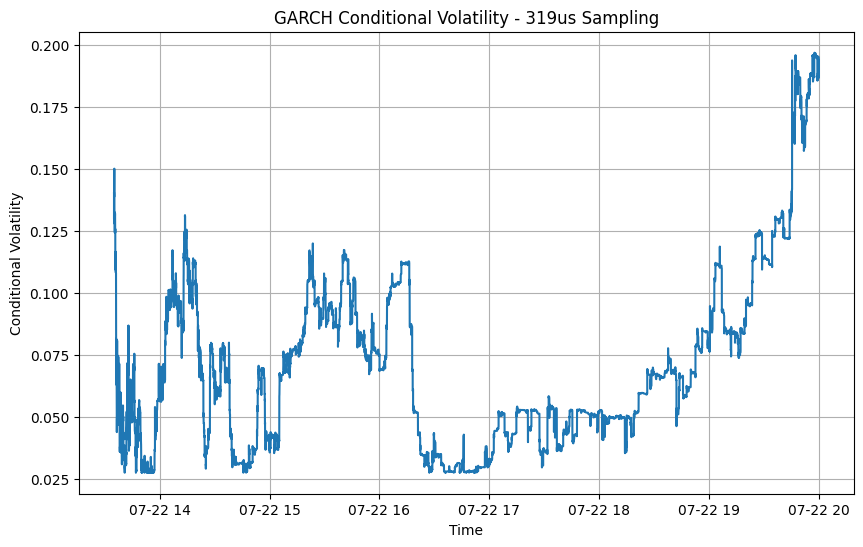

<Figure size 640x480 with 0 Axes>

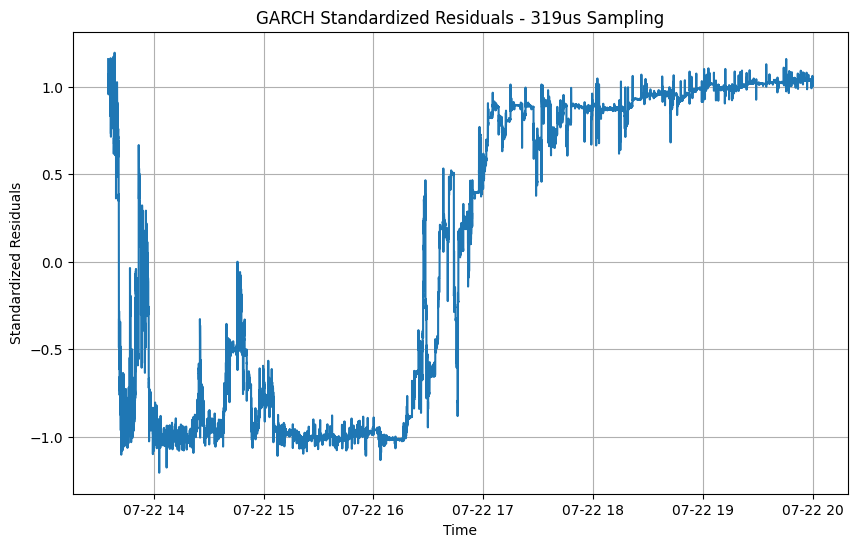

Hurst Exponent for 319us Sampling: 0.538806903129344
Hurst Exponent for 319us Sampling: 0.4908010126745531

Fitting GARCH model for 1598us sampling


/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008461. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                70726.2
Distribution:                  Normal   AIC:                          -141444.
Method:            Maximum Likelihood   BIC:                          -141409.
                                        No. Observations:                52338
Date:                Sun, Mar 30 2025   Df Residuals:                    52337
Time:                        14:22:04   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             8.3448  1.179e-03   7078.979      0.000 [  8.342,  8.34

<Figure size 640x480 with 0 Axes>

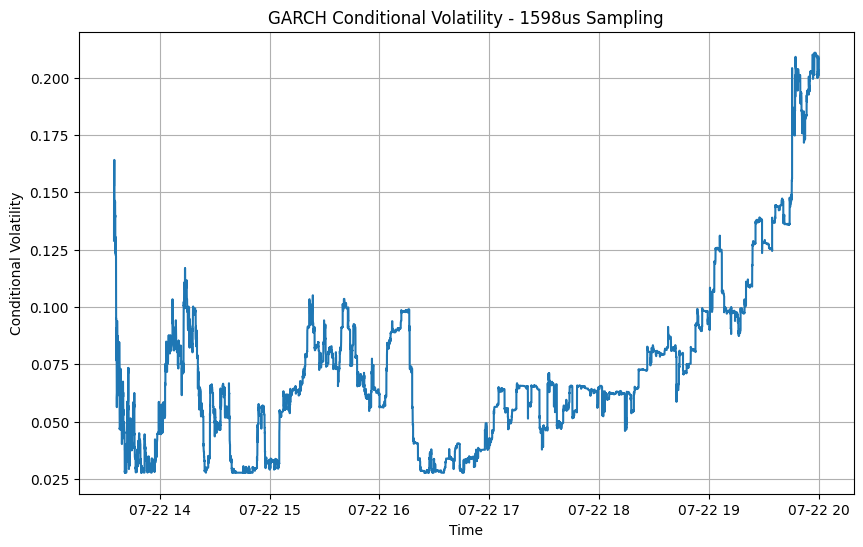

<Figure size 640x480 with 0 Axes>

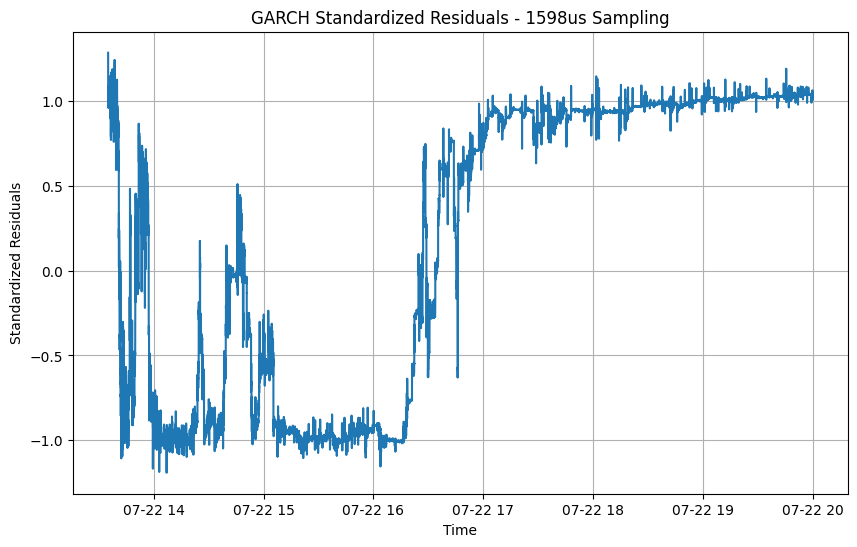

Hurst Exponent for 1598us Sampling: 0.5433637722819002
Hurst Exponent for 1598us Sampling: 0.5128245154314786

Fitting GARCH model for 3196us sampling


/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008495. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                71089.9
Distribution:                  Normal   AIC:                          -142172.
Method:            Maximum Likelihood   BIC:                          -142137.
                                        No. Observations:                47424
Date:                Sun, Mar 30 2025   Df Residuals:                    47423
Time:                        14:22:05   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             8.3373  1.979e-06  4.212e+06      0.000 [  8.337,  8.33

<Figure size 640x480 with 0 Axes>

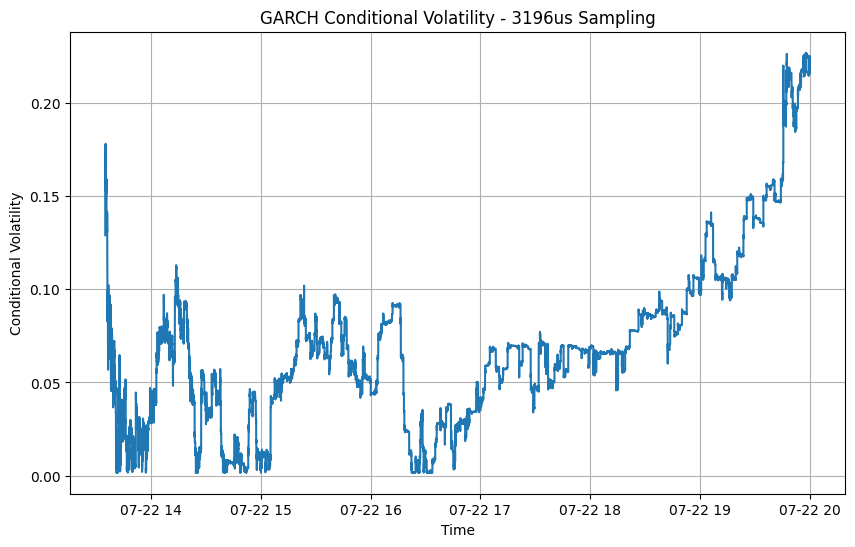

<Figure size 640x480 with 0 Axes>

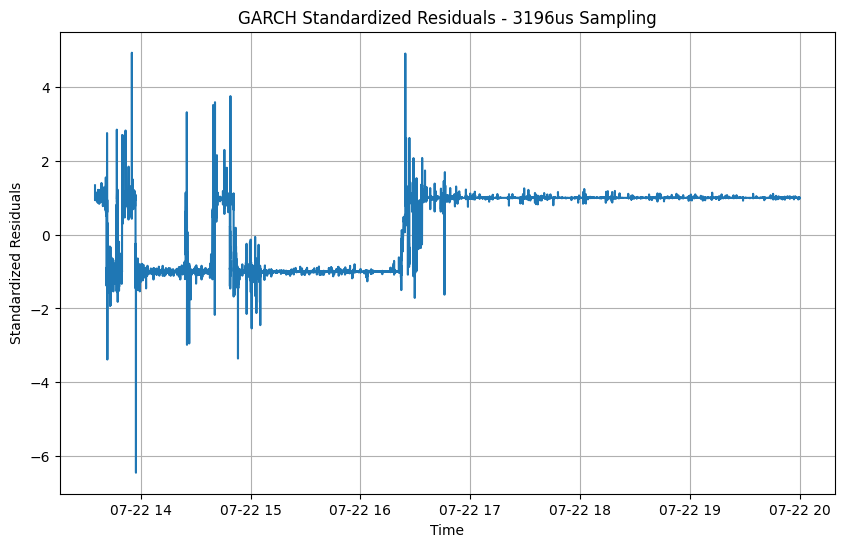

Hurst Exponent for 3196us Sampling: 0.5388179135815767
Hurst Exponent for 3196us Sampling: 0.4867551974992244

Fitting GARCH model for 9589us sampling


/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008448. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                43259.0
Distribution:                  Normal   AIC:                          -86509.9
Method:            Maximum Likelihood   BIC:                          -86475.4
                                        No. Observations:                41136
Date:                Sun, Mar 30 2025   Df Residuals:                    41135
Time:                        14:22:06   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             8.3581  7.962e-04  1.050e+04      0.000 [  8.357,  8.36

<Figure size 640x480 with 0 Axes>

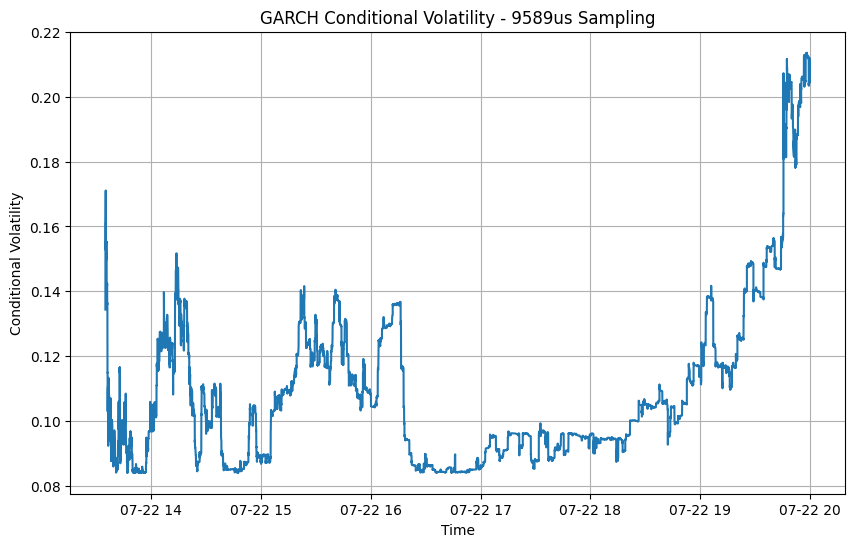

<Figure size 640x480 with 0 Axes>

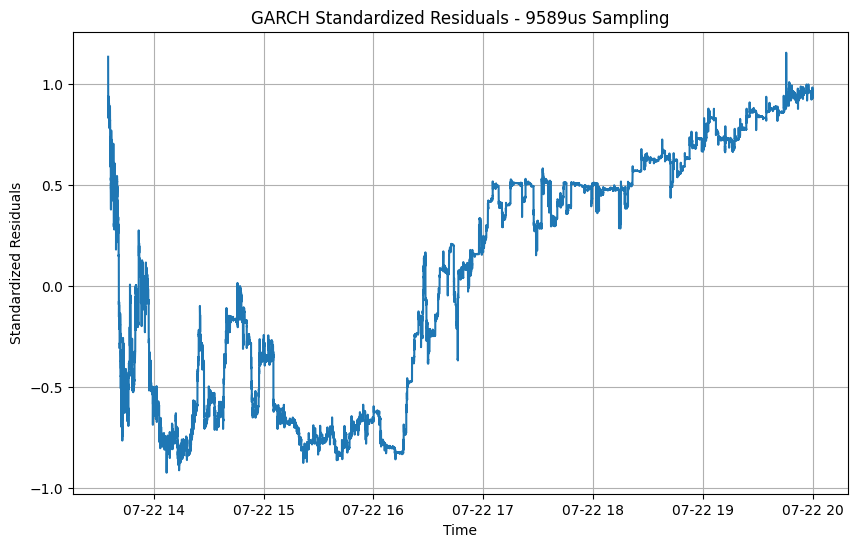

Hurst Exponent for 9589us Sampling: 0.5507602905171527
Hurst Exponent for 9589us Sampling: 0.4971778446075848

Fitting GARCH model for 31965us sampling


/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008292. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                46922.7
Distribution:                  Normal   AIC:                          -93837.5
Method:            Maximum Likelihood   BIC:                          -93803.6
                                        No. Observations:                34822
Date:                Sun, Mar 30 2025   Df Residuals:                    34821
Time:                        14:22:06   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             8.3480  1.857e-03   4496.480      0.000 [  8.344,  8.35

<Figure size 640x480 with 0 Axes>

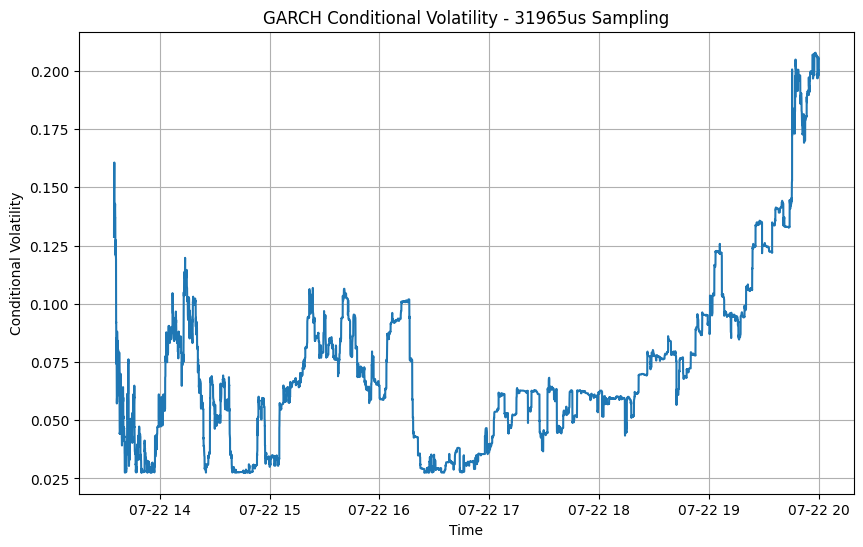

<Figure size 640x480 with 0 Axes>

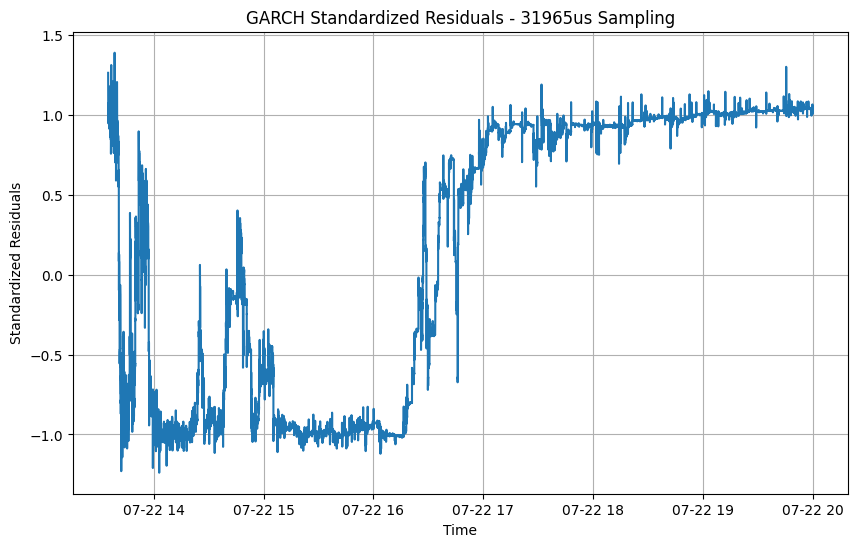

Hurst Exponent for 31965us Sampling: 0.5468970006564481
Hurst Exponent for 31965us Sampling: 0.5140471544602346

Fitting GARCH model for 319653us sampling


/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007455. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                14109.8
Distribution:                  Normal   AIC:                          -28211.5
Method:            Maximum Likelihood   BIC:                          -28179.4
                                        No. Observations:                22654
Date:                Sun, Mar 30 2025   Df Residuals:                    22653
Time:                        14:22:07   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             8.3654  6.718e-04  1.245e+04      0.000 [  8.364,  8.36

<Figure size 640x480 with 0 Axes>

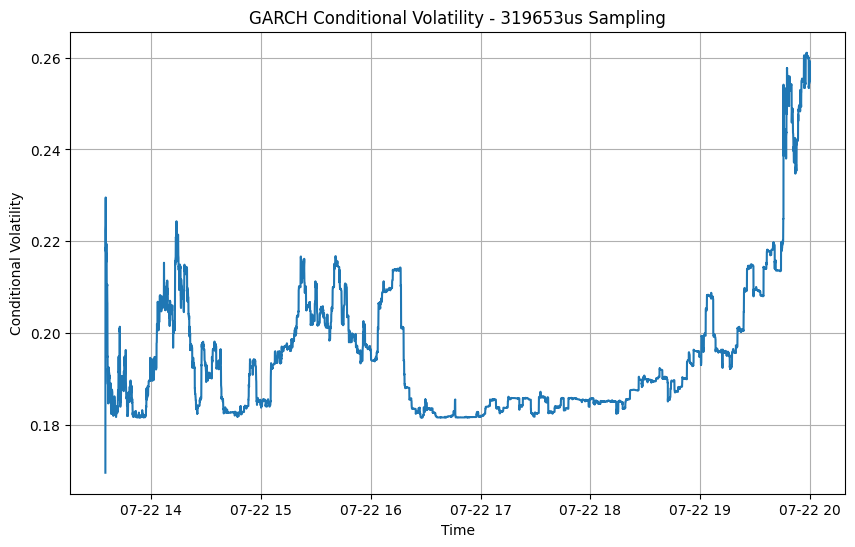

<Figure size 640x480 with 0 Axes>

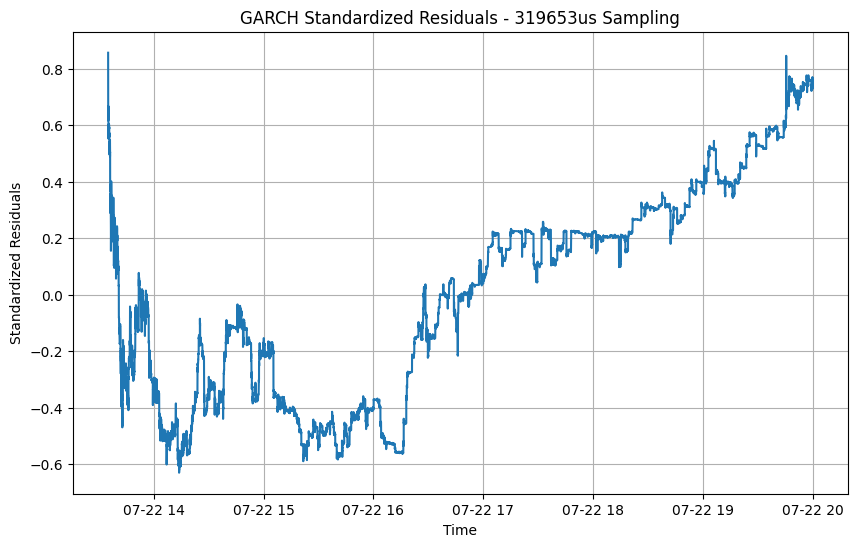

Hurst Exponent for 319653us Sampling: 0.547925010656633
Hurst Exponent for 319653us Sampling: 0.47419896707603293

Fitting GARCH model for 958961us sampling


/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006824. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                21645.9
Distribution:                  Normal   AIC:                          -43283.8
Method:            Maximum Likelihood   BIC:                          -43253.3
                                        No. Observations:                15085
Date:                Sun, Mar 30 2025   Df Residuals:                    15084
Time:                        14:22:08   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             8.3855  2.498e-03   3357.199      0.000 [  8.381,  8.39

<Figure size 640x480 with 0 Axes>

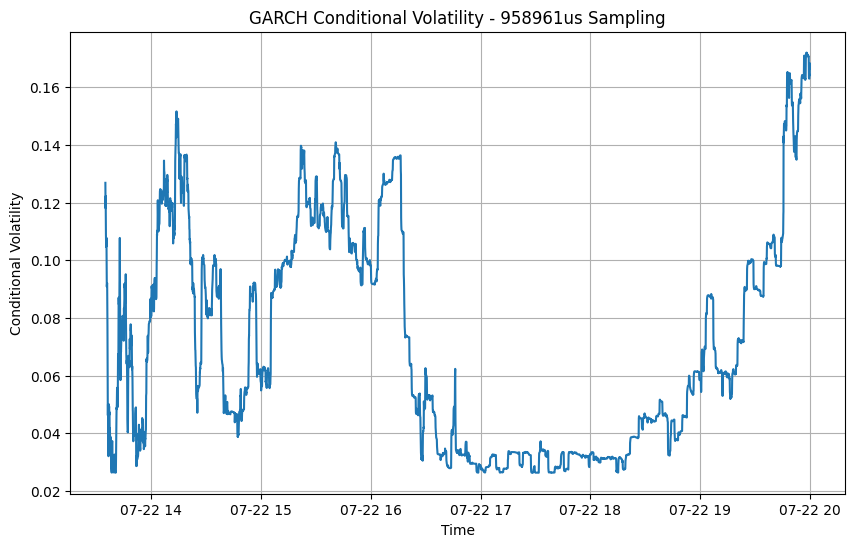

<Figure size 640x480 with 0 Axes>

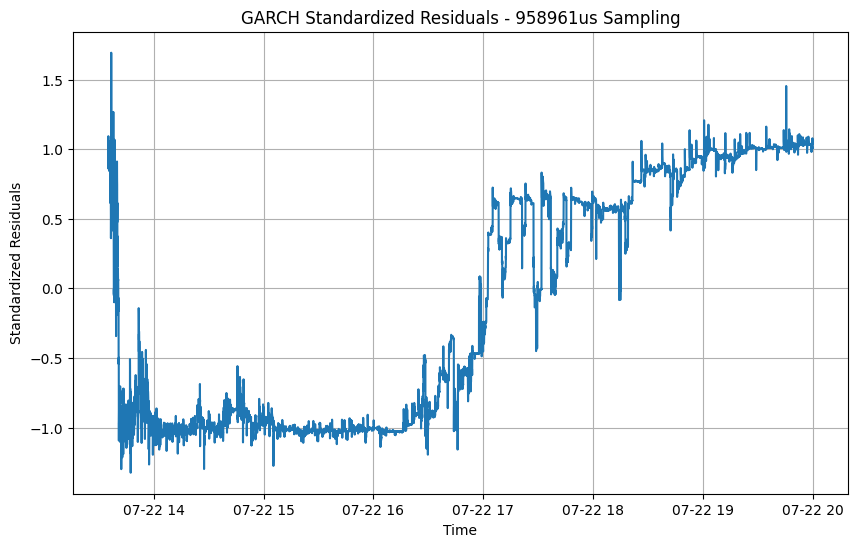

Hurst Exponent for 958961us Sampling: 0.5463794584559462
Hurst Exponent for 958961us Sampling: 0.49365125126352744

Fitting GARCH model for 3196538us sampling
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6436.55
Distribution:                  Normal   AIC:                          -12865.1
Method:            Maximum Likelihood   BIC:                          -12837.9
                                        No. Observations:                 6701
Date:                Sun, Mar 30 2025   Df Residuals:                     6700
Time:                        14:22:08   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  9

/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006128. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<Figure size 640x480 with 0 Axes>

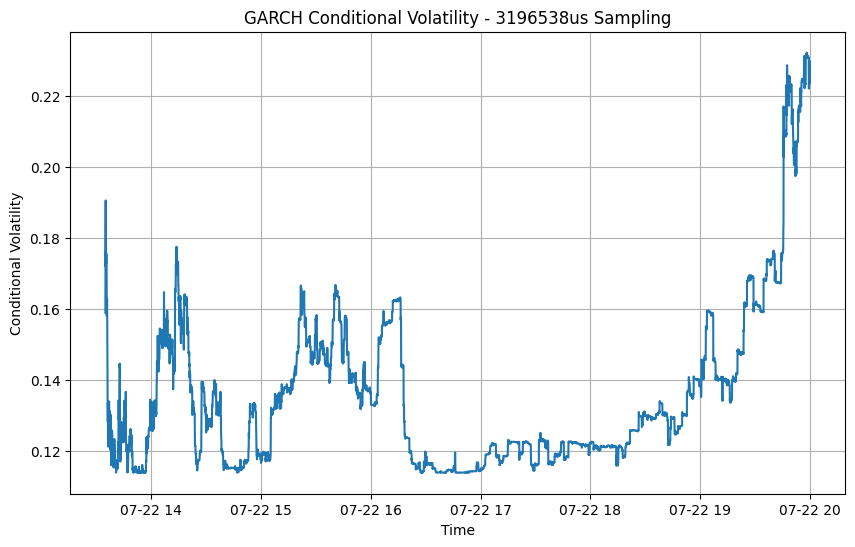

<Figure size 640x480 with 0 Axes>

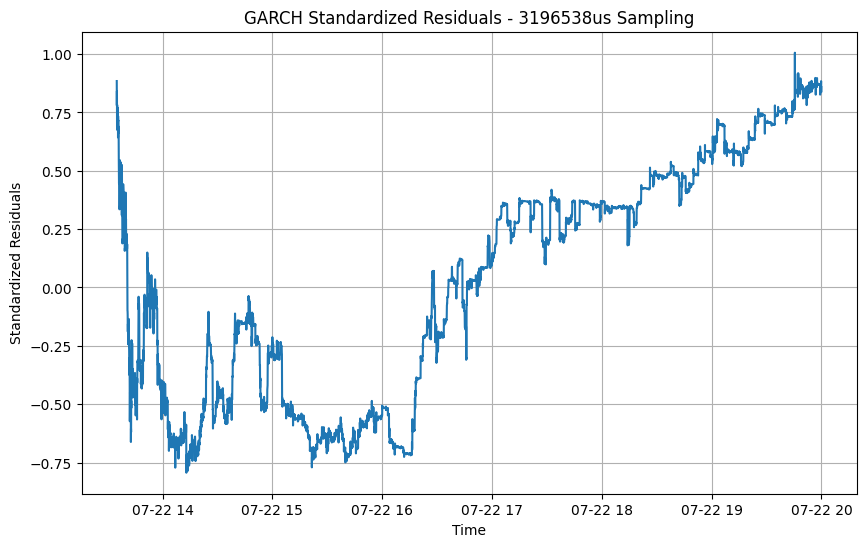

Hurst Exponent for 3196538us Sampling: 0.5495047747268439
Hurst Exponent for 3196538us Sampling: 0.4587581816916165

Fitting GARCH model for 9589616us sampling
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3697.23
Distribution:                  Normal   AIC:                          -7386.47
Method:            Maximum Likelihood   BIC:                          -7363.33
                                        No. Observations:                 2407
Date:                Sun, Mar 30 2025   Df Residuals:                     2406
Time:                        14:22:08   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  

/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005985. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<Figure size 640x480 with 0 Axes>

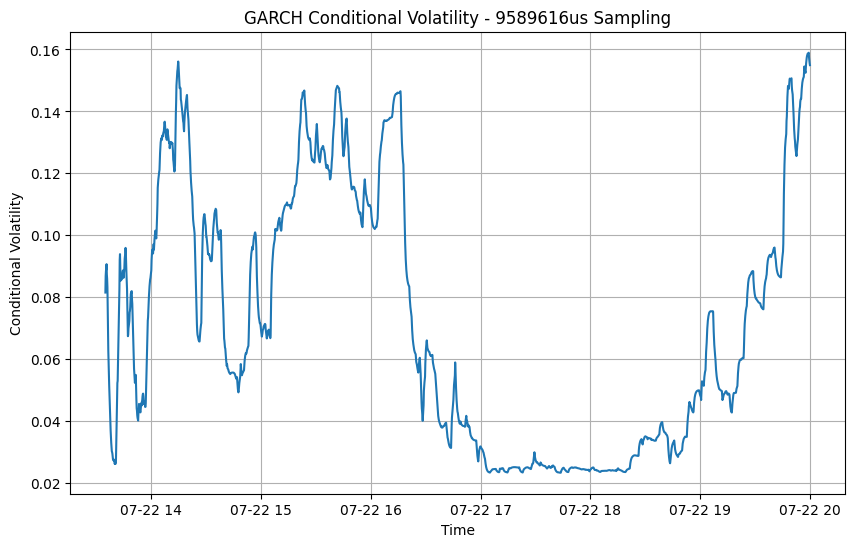

<Figure size 640x480 with 0 Axes>

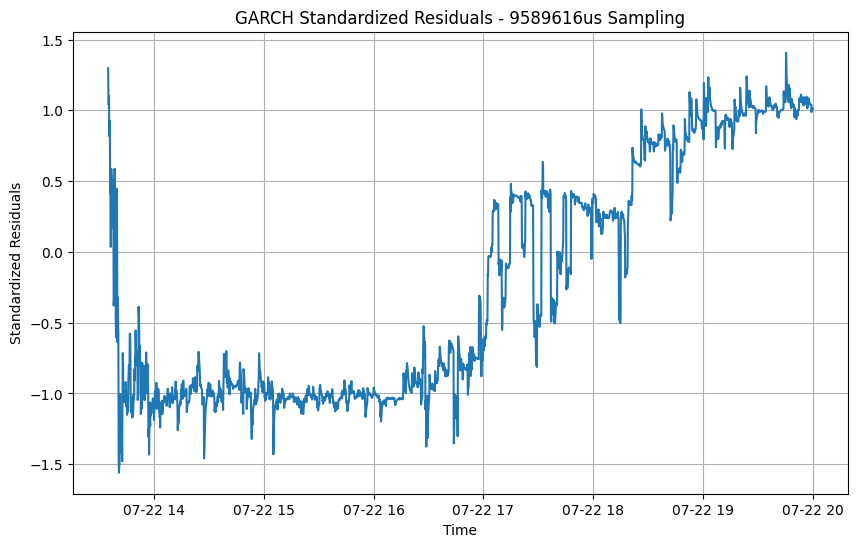

Hurst Exponent for 9589616us Sampling: 0.5999418119006781
Hurst Exponent for 9589616us Sampling: 0.40471857767571384

Fitting GARCH model for 31965389us sampling
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1093.73
Distribution:                  Normal   AIC:                          -2179.46
Method:            Maximum Likelihood   BIC:                          -2161.12
                                        No. Observations:                  723
Date:                Sun, Mar 30 2025   Df Residuals:                      722
Time:                        14:22:09   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|

/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<Figure size 640x480 with 0 Axes>

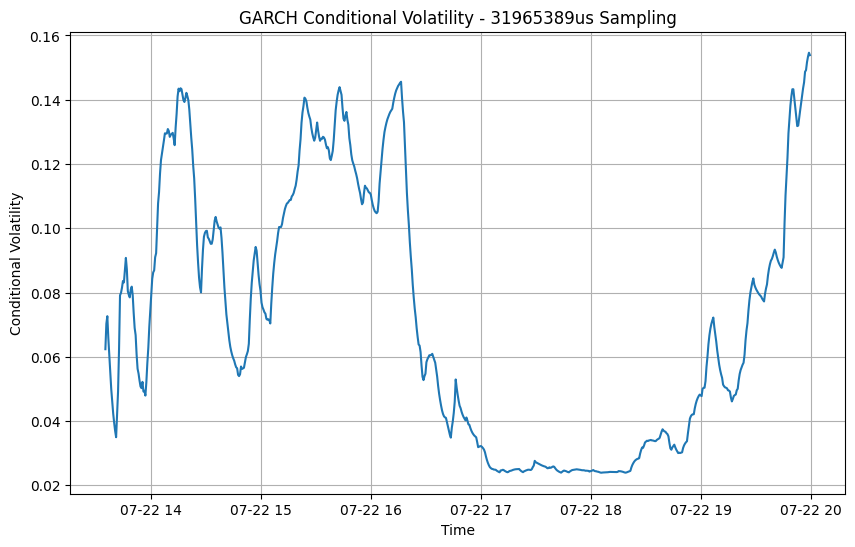

<Figure size 640x480 with 0 Axes>

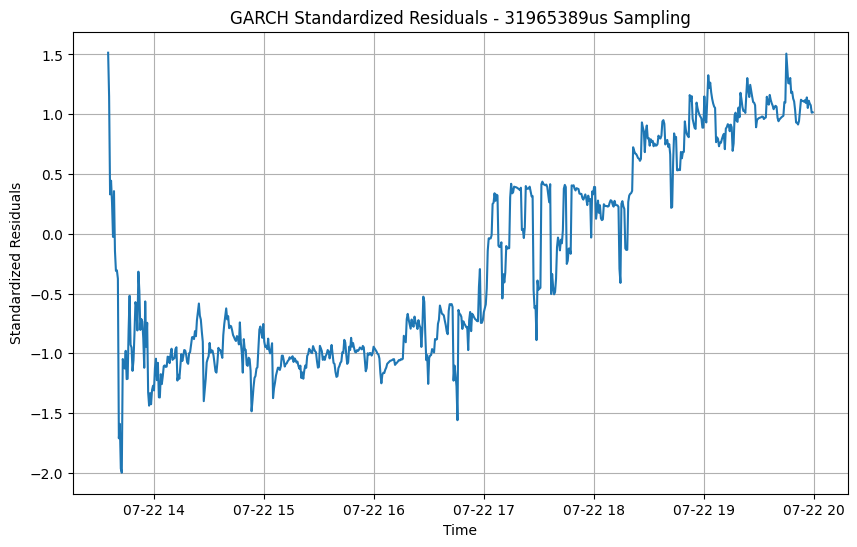

Hurst Exponent for 31965389us Sampling: 0.6450044814601108
Hurst Exponent for 31965389us Sampling: 0.3550180537853073

Fitting GARCH model for 95896167us sampling
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                354.597
Distribution:                  Normal   AIC:                          -701.194
Method:            Maximum Likelihood   BIC:                          -687.238
                                        No. Observations:                  242
Date:                Sun, Mar 30 2025   Df Residuals:                      241
Time:                        14:22:09   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t

/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006097. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<Figure size 640x480 with 0 Axes>

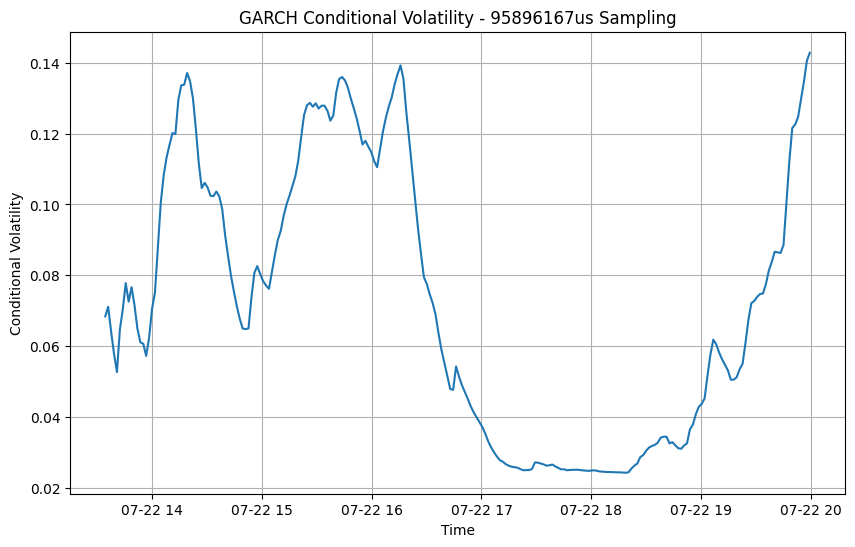

<Figure size 640x480 with 0 Axes>

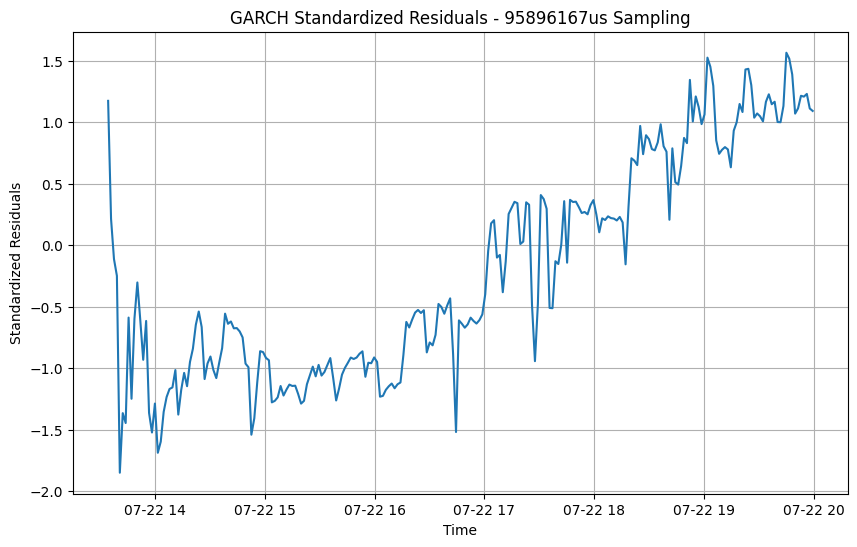

Hurst Exponent for 95896167us Sampling: 0.49115735832195057
Hurst Exponent for 95896167us Sampling: 0.22586517265569878

Fitting GARCH model for 319653890us sampling
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                109.503
Distribution:                  Normal   AIC:                          -211.006
Method:            Maximum Likelihood   BIC:                          -201.844
                                        No. Observations:                   73
Date:                Sun, Mar 30 2025   Df Residuals:                       72
Time:                        14:22:09   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P

/home/janis/HFTP2/HFT/.venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<Figure size 640x480 with 0 Axes>

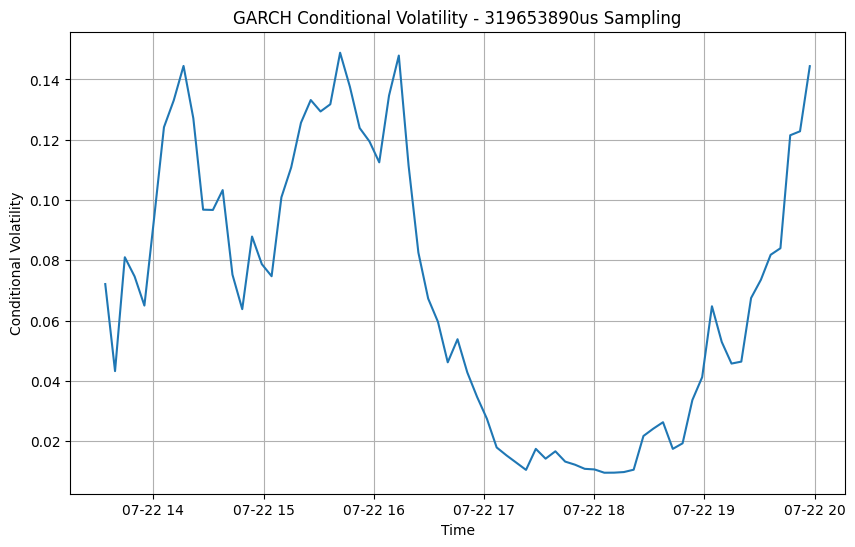

<Figure size 640x480 with 0 Axes>

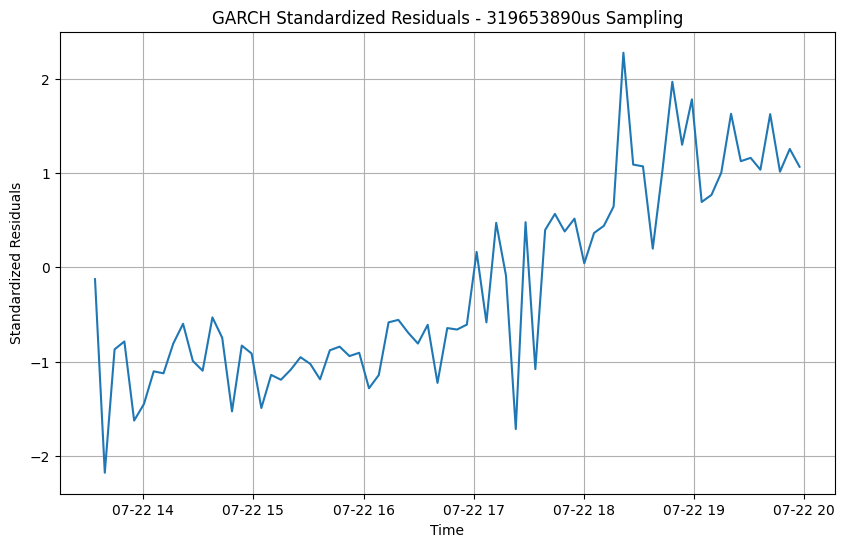

ValueError: Series length must be greater or equal to 100

: 

In [ ]:
import arch
import matplotlib.pyplot as plt
import numpy as np

for scale in time_scales:
    print(f"\nFitting GARCH model for {scale} sampling")
    
    # Get first day data only
    first_day = dfs[scale]["ts_event"].dt.date()[0]
    mask = dfs[scale]["ts_event"].dt.date() == first_day
    first_day_data = dfs[scale].filter(mask)
    
    # Get returns data for first day only
    returns = first_day_data.select("mid_price").to_numpy().flatten()
    
    # Create and fit GARCH(1,1) model with constant mean
    model = arch.arch_model(returns, mean='Constant', vol='GARCH', p=1, q=1)
    results = model.fit(disp='off')  # Suppress optimization output
    print(results.summary())

    # Get conditional volatility
    cvol = results.conditional_volatility
    
    # Get standardized residuals 
    stres = results.resid / cvol
    
    # Make predictions
    forecasts = results.forecast(horizon=3)
    
    # Plot conditional volatility
    plt.figure(figsize=(10,6))
    plt.plot(first_day_data["ts_event"], cvol)
    plt.title(f"GARCH Conditional Volatility - {scale} Sampling")
    plt.xlabel("Time") 
    plt.ylabel("Conditional Volatility")
    plt.grid(True)
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_garch_vol_{scale}.png")

    # Plot standardized residuals
    plt.figure(figsize=(10,6))
    plt.plot(first_day_data["ts_event"], stres)
    plt.title(f"GARCH Standardized Residuals - {scale} Sampling")
    plt.xlabel("Time")
    plt.ylabel("Standardized Residuals")
    plt.grid(True)
    plt.show()
    # vol extraction
    vol = cvol[~np.isnan(cvol)]
    vol1 = vol[len(vol)//2:]
    vol2 = vol[:len(vol)//2]
    H, c, data = compute_Hc(vol1)
    H2, c2, data2 = compute_Hc(vol2)
    print(f"Hurst Exponent for {scale} Sampling: {H}")
    print(f"Hurst Exponent for {scale} Sampling: {H2}")
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_garch_resid_{scale}.png")
